In [2]:
import tqdm
import numpy as np
import pandas as pd
from collections import Counter
import math
import joblib

import numpy as np
import pandas as pd
from collections import Counter
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
# 你的 Node 和 Network 类定义在这里

from scipy.stats.qmc import LatinHypercube
import numpy as np

def simulate_network_for_parameters(network, param, empirical_data, num_seeds=3):
    """
    使用给定参数和多个随机种子运行网络模拟。
    返回模拟结果的摘要统计。
    """

    errors = []
    for seed in range(num_seeds):
        np.random.seed(seed)
        # 如有必要，此处重置网络到初始状态
        simulation_results = network.simulate_steps(90, *param)  # 假设96天
        i = 0
        pre_w_risk_p = {}
        pre_m_risk_p = {}
        pre_sentiment_high_p = {}
        pre_sentiment_middle_p = {}

        for index in range(1, 90, 7):
            start = index
            end = start + 7
            results_slice = simulation_results[start:end]
            m_media_risk_p = np.mean([step['m_media'].get('R', 0) for step in results_slice])
            w_media_risk_p = np.mean([step['w_media'].get('R', 0) for step in results_slice])
            o_people_high_p = np.mean([step['o_people'].get('H', 0) for step in results_slice])
            o_people_middle_p = np.mean([step['o_people'].get('M', 0) for step in results_slice])
            pre_w_risk_p[i] = w_media_risk_p
            pre_m_risk_p[i] = m_media_risk_p
            pre_sentiment_high_p[i] = o_people_high_p
            pre_sentiment_middle_p[i] = o_people_middle_p
            i += 1

        pre_data = {
            'w_risk_p': pre_w_risk_p,
            'm_risk_p': pre_m_risk_p,
            'sentiment_high_p': pre_sentiment_high_p,
            'sentiment_middle_p': pre_sentiment_middle_p
        }
        error = calculate_error(pre_data, empirical_data)
        errors.append(error)

    avg_error = np.mean(errors)

    if meets_error_criteria(avg_error):
        return {'result': 'fitting', 'param': param, 'error': avg_error}

    # 处理结果以计算摘要统计或误差度量
    return {'result': 'not fitting', 'param': param, 'error': avg_error}



def calculate_error(simulation_results, empirical_data):
    """
    计算模拟结果与经验数据之间的误差。
    
    参数:
    - simulation_results: 模拟结果，假设为字典形式，包含各种状态的比率。
    - empirical_data: 经验数据，也假设为字典形式，结构与模拟结果相同。
    
    返回:
    - error: 误差值，这里简单使用绝对误差的平均值。
    """
    error_sum = 0
    for key in simulation_results.keys():
        for step in range(1, 14):
            if step in simulation_results[key]:
                error_sum += abs(simulation_results[key][step] - empirical_data[key][step])
        # error_sum += abs(simulation_results[key] - empirical_data[key])
    mean_error = error_sum / 52
    return mean_error

def meets_error_criteria(error):
    """
    判断给定的误差是否满足阈值条件。
    
    参数:
    - error: 误差值。
    
    返回:
    - bool: 表示误差是否在可接受范围内。
    """
    # 以0.01为误差阈值的示例，这个值根据你的需求进行调整
    error_threshold = 0.07
    return error < error_threshold



def select_parameters_based_on_error(all_params, all_results, empirical_data):
    """
    根据指定的误差阈值选择参数组合。
    """
    selected_params = []
    for params, results in zip(all_params, all_results):
        # 实现基于结果和经验数据的误差计算
        error = calculate_error(results, empirical_data)
        if meets_error_criteria(error):
            selected_params.append(params)
    return selected_params


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_history_with_empirical(history, empirical_data):
    # 准备绘图数据
    time_steps = list(range(0, len(history)))
    data = {
        'm_media_R': [step['m_media'].get('R', 0) for step in history],
        'w_media_R': [step['w_media'].get('R', 0) for step in history],
        'o_people_H': [step['o_people'].get('H', 0) for step in history],
        'o_people_M': [step['o_people'].get('M', 0) for step in history],
        'l_people_L': [step['o_people'].get('L', 0) for step in history],
        # 添加其他需要绘制的状态
    }
    
    # 绘制折线图
    plt.figure(figsize=(10, 6))
    for label, values in data.items():
        plt.plot(time_steps, values, label=label)
    
    # 添加经验数据的散点
    # 将经验数据的周数转换为天数，假设第一周对应的时间步为0 (第0天)
    week_to_day = lambda week: week * 7
    
    # 遍历经验数据，添加散点
    for week, risk_p in empirical_data['w_risk_p'].items():
        plt.scatter(week_to_day(week), risk_p, color='orange', label='Empirical W Risk P' if week == 0 else "")
        
    for week, risk_p in empirical_data['m_risk_p'].items():
        plt.scatter(week_to_day(week), risk_p, color='blue', label='Empirical M Risk P' if week == 0 else "")
        
    for week, sentiment_p in empirical_data['sentiment_high_p'].items():
        plt.scatter(week_to_day(week), sentiment_p, color='green', label='Empirical High Sentiment P' if week == 0 else "")
    
    for week, sentiment_p in empirical_data['sentiment_middle_p'].items():
        plt.scatter(week_to_day(week), sentiment_p, color='red', label='Empirical Middle Sentiment P' if week == 0 else "")

    for week, sentiment_p in empirical_data['sentiment_low_p'].items():
        plt.scatter(week_to_day(week), sentiment_p, color='purple', label='Empirical Low Sentiment P' if week == 0 else "")
        
    # 为了避免标签重复，仅在第一次添加标签时指定
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # 去重
    plt.legend(by_label.values(), by_label.keys())
    
    plt.title('State Proportions Over Time with Empirical Data')
    plt.xlabel('Time Step (Days)')
    plt.ylabel('Proportion')
    plt.grid(True)
    plt.show()


In [3]:
import math
from collections import Counter
from scipy.stats import entropy

class Node:
    def __init__(self, name, node_type, risk=None, sentiment=None, intensity=None):
        self.name = name
        self.type = node_type
        self.risk = risk
        self.sentiment = sentiment
        self.intensity = intensity
        self.influencers = []
        # self.sigma = sigma

    def add_influencer(self, influencer):
        self.influencers.append(influencer)

    def calculate_n_major(self):
        # 仅适用于 o_people 类型的节点
        sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
        if sentiment_counter:
            return max(sentiment_counter.values())  # 返回最多的情绪类别的数量
        return 0

    def calculate_influencers_sentiment_distribution(self):
        sentiment_counts = Counter(inf.sentiment for inf in self.influencers if inf.sentiment)
        n_high = sentiment_counts.get('H', 0)
        n_low = sentiment_counts.get('L', 0)
        n_middle = sentiment_counts.get('M', 0)
        return n_high, n_low, n_middle
    
    def update_m_media(self, params):
        if self.type == 'm_media':
            alpha = params['alpha']
            # n_high, n_low, n_middle = self.calculate_influencers_sentiment_distribution() # 计算情绪分布
            d = params['d']
            n_high_global = params['n_high']
            n_low_global = params['n_low']
            n_middle_global = params['n_middle']
            sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
            # 添加默认情绪类别为 0
            for sentiment in ['H', 'M', 'L']:
                if sentiment not in sentiment_counter:
                    sentiment_counter[sentiment] = 0
            
            n_high_local = sentiment_counter.get('H', 0)
            n_low_local = sentiment_counter.get('L', 0)
            n_middle_local = sentiment_counter.get('M', 0)

            # n_high = (n_high_local + n_high_global) / 2
            # n_low = (n_low_local + n_low_global) / 2
            # n_middle = (n_middle_local + n_middle_global) / 2

            n_high = n_high_local
            n_low = n_low_local
            n_middle = n_middle_local

            if n_middle > n_high and n_middle > n_low:
                pass

            elif n_high > n_middle and n_high > n_low:
                d = 2 * n_high - n_middle - n_low
                Pu = 1 - math.exp(-alpha * d)
                if Pu > np.random.random():
                    self.risk = 'NR'

            elif n_low > n_middle and n_low > n_high:
                d = 2 * n_low - n_middle - n_high
                Pu = 1 - math.exp(-alpha * d)
                if Pu > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'
            
            else:   # 三者相等
                d = n_middle
                Pu = 1 - math.exp(-alpha * d)
                if Pu > np.random.random():
                    self.risk = 'NR'

    def update_m_media_gv(self, params, government_effect_m):
        if self.type == 'm_media':
            alpha = params['alpha']
            g_m = params['g_m']
            # n_high, n_low, n_middle = self.calculate_influencers_sentiment_distribution() # 计算情绪分布
            d = params['d']
            n_high_global = params['n_high']
            n_low_global = params['n_low']
            n_middle_global = params['n_middle']
            sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
            # 添加默认情绪类别为 0
            for sentiment in ['H', 'M', 'L']:
                if sentiment not in sentiment_counter:
                    sentiment_counter[sentiment] = 0
            
            n_high_local = sentiment_counter.get('H', 0)
            n_low_local = sentiment_counter.get('L', 0)
            n_middle_local = sentiment_counter.get('M', 0)

            # n_high = (n_high_local + n_high_global) / 2
            # n_low = (n_low_local + n_low_global) / 2
            # n_middle = (n_middle_local + n_middle_global) / 2

            n_high = n_high_local
            n_low = n_low_local
            n_middle = n_middle_local

            if n_middle > n_high and n_middle > n_low:
                Pu = g_m
                if Pu > np.random.random():
                    self.risk = 'NR'

            elif n_high > n_middle and n_high > n_low:
                d = 2 * n_high - n_middle - n_low
                Pu = (1 - math.exp(-alpha * d) + g_m)
                if Pu > np.random.random():
                    self.risk = 'NR'
                

            elif n_low > n_middle and n_low > n_high:
                d = 2 * n_low - n_middle - n_high
                Pu = (1 - math.exp(-alpha * d) + g_m) # 在这里我添加了政府对主流媒体的影响，它是一个开口朝下的二次函数，使得降低风险概率增加
                if Pu > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR' 

            else:
                d = n_middle
                Pu = (1 - math.exp(-alpha * d) + g_m)
                if Pu > np.random.random():
                    self.risk = 'NR'
                # else:
                #     self.risk = 'R'

        
    def update_w_media(self, params):
        if self.type == 'w_media':

            beta = params['beta']
            # n_middle = params['n_middle']
            # n_high = params['n_high']
            # n_low = params['n_low']
            n_high_global = params['n_high']
            n_low_global = params['n_low']
            n_middle_global = params['n_middle']
            risk_global_m = params['risk_m']
            norisk_global_m = params['norisk_m']
            risk_global_w = params['risk_w']
            norisk_global_w = params['norisk_w']

            sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
            # 添加默认情绪类别为 0
            for sentiment in ['H', 'M', 'L']:
                if sentiment not in sentiment_counter:
                    sentiment_counter[sentiment] = 0
            
            n_high_local = sentiment_counter.get('H', 0)
            n_low_local = sentiment_counter.get('L', 0)
            n_middle_local = sentiment_counter.get('M', 0)

            risk_counter = Counter([inf.risk for inf in self.influencers if inf.risk])
            # 添加默认风险类别为 0
            for risk in ['R', 'NR']:
                if risk not in risk_counter:
                    risk_counter[risk] = 0
            risk_local = risk_counter.get('R', 0)
            norisk_local = risk_counter.get('NR', 0) 

                       

            # n_high = (n_high_local + n_high_global) / 2
            # n_low = (n_low_local + n_low_global) / 2
            # n_middle = (n_middle_local + n_middle_global) / 2

            n_high = n_high_local
            n_low = n_low_local
            n_middle = n_middle_local

            total_sentiments = sum(sentiment_counter.values())

            if total_sentiments > 0:
                # 计算情绪的概率分布
                sentiment_probs = [sentiment_counter[s] / total_sentiments for s in ['H', 'M', 'L']]
            else:
                # 如果没有情绪数据，设定为均匀分布或采取其他处理
                sentiment_probs = [1/3, 1/3, 1/3]  # 例如设定为均匀分布
                # print("Warning: No sentiment data, using default equal probabilities.")
                
            sentiment_entropy = entropy(sentiment_probs)

            d = sentiment_entropy

            if n_high > n_middle and n_high > n_low:
                pass
            
            elif n_low > n_middle and n_low > n_high:
                # d = n_low
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'

            elif n_middle > n_high and n_middle > n_low:
                # d = n_middle
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'
            
            elif n_low == n_middle and n_low == n_high:
                # d = n_middle
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'
            
            else: # 三者相等
                # d = n_middle
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
            # else:
            #     self.risk = 'R'

            norisk = norisk_local 
            risk = risk_local 
            # norisk = norisk_global_m + norisk_global_w
            # risk = risk_global_m + risk_global_w
            Pv_2 = (np.tanh(norisk - risk) + 1) / 2  # 使用的是局部信息
            if Pv_2 > np.random.random():
                self.risk = 'NR'
            # else:
            #     self.risk = 'NR'

    
    def update_w_media_gv(self, params, government_effect_w):
        # 特殊时期，自媒体会降低风险报道的概率
        if self.type == 'w_media':

            beta = params['beta']
            # n_middle = params['n_middle']
            # n_high = params['n_high']
            # n_low = params['n_low']
            sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
            # 添加默认情绪类别为 0
            for sentiment in ['H', 'M', 'L']:
                if sentiment not in sentiment_counter:
                    sentiment_counter[sentiment] = 0
            
            n_high = sentiment_counter.get('H', 0)
            n_low = sentiment_counter.get('L', 0)
            n_middle = sentiment_counter.get('M', 0)

            risk_global_m = params['risk_m']
            norisk_global_m = params['norisk_m']

            risk_global_w = params['risk_w']
            norisk_global_w = params['norisk_w']


            risk_counter = Counter([inf.risk for inf in self.influencers if inf.risk])
            # 添加默认风险类别为 0
            for risk in ['R', 'NR']:
                if risk not in risk_counter:
                    risk_counter[risk] = 0

            risk_local = risk_counter.get('R', 0)
            norisk_local = risk_counter.get('NR', 0)

            total_sentiments = sum(sentiment_counter.values())

            if total_sentiments > 0:
                # 计算情绪的概率分布
                sentiment_probs = [sentiment_counter[s] / total_sentiments for s in ['H', 'M', 'L']]
            else:
                # 如果没有情绪数据，设定为均匀分布或采取其他处理
                sentiment_probs = [1/3, 1/3, 1/3]  # 例如设定为均匀分布
                # print("Warning: No sentiment data, using default equal probabilities.")
                
            sentiment_entropy = entropy(sentiment_probs)

            d = sentiment_entropy
            
            if n_high > n_middle and n_high > n_low:
                pass
            
            elif n_low > n_middle and n_low > n_high:
                # d = n_low
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'

            elif n_middle > n_high and n_middle > n_low:
                # d = n_middle
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'
            
            elif n_low == n_middle and n_low == n_high:
                # d = n_middle
                Pv_1 = 1 - math.exp(-beta * d)
                if Pv_1 > np.random.random():
                    self.risk = 'R'
                # else:
                #     self.risk = 'NR'
            
            else: # 三者相等
                pass
            
            norisk = norisk_local 
            risk = risk_local 
            # norisk = norisk_global_m + norisk_global_w
            # risk = risk_global_m + risk_global_w
            Pv_2 = (np.tanh(norisk - risk) + 1) / 2  # 使用的是局部信息
            if Pv_2 > np.random.random():
                self.risk = 'NR'
            # else:
            #     self.risk = 'R'


    def update_o_people(self, params):
        if self.type == 'o_people':
            intensity = self.intensity
            # 这里的r应该规范化
            risk_m = params['risk_m']
            risk_w = params['risk_w']
            norisk_m = params['norisk_m']
            norisk_w = params['norisk_w']
            theta = params['theta']
            sigma = params['sigma']
            zeta = params['zeta']
            miu = params['miu']
            risk_global = risk_m + risk_w
            norisk_global = norisk_m + norisk_w
            risk_counter = Counter([inf.risk for inf in self.influencers if inf.risk])
            # 添加默认风险类别为 0
            for risk in ['R', 'NR']:
                if risk not in risk_counter:
                    risk_counter[risk] = 0

            risk_local = risk_counter.get('R', 0)
            norisk_local = risk_counter.get('NR', 0)

            # risk = (risk_local + risk_global) / 2
            # norisk = (norisk_local + risk_global) / 2
            # risk = risk_local
            # norisk = norisk_local

            risk = risk_global
            norisk = norisk_global

            sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
            # 添加默认情绪类别为 0
            for sentiment in ['H', 'M', 'L']:
                if sentiment not in sentiment_counter:
                    sentiment_counter[sentiment] = 0

            if self.sentiment == 'H':
                d1 = norisk - risk
                d2 = sentiment_counter.get('M', 0) + sentiment_counter.get('L', 0) - sentiment_counter.get('H', 0)
            elif self.sentiment == 'M':
                # 绝对值
                d1 = abs(norisk - risk)  # 这里选用了绝对值，是因为我们认为风险和非风险的差距越大，越容易产生情绪的变化
                d2 = sentiment_counter.get('H', 0) + sentiment_counter.get('L', 0) - sentiment_counter.get('M', 0)
            elif self.sentiment == 'L':
                d1 = risk - norisk
                d2 = sentiment_counter.get('H', 0) + sentiment_counter.get('M', 0) - sentiment_counter.get('L', 0)
            
            # intensity越小，越容易产生情绪的变化
            intensity = intensity - ((np.tanh(theta * d1) + np.tanh(sigma * d2)) + 2) / 4 # 这里我们添加了risk信息机制还有homophily机制

            d = risk - norisk
            Pw = (1 + np.tanh(d)) / 2

            if intensity > 1:
                intensity = 1
            elif intensity < 0:
                intensity = 0

            # 判断所有 sentiment_counter 的值是否相等
            def all_values_equal(d):
                values = list(d.values())
                return values.count(values[0]) == len(values)
            
            # 修改后的代码
            if intensity > np.random.random():
                if self.sentiment == 'M':
                    if np.random.random() < zeta:
                        if Pw > np.random.random():
                            self.sentiment = 'H'
                        else:
                            self.sentiment = 'L'
                        # else:
                        #     self.sentiment = np.random.choice(['H', 'L'])
                    else:
                        if all_values_equal(sentiment_counter):
                            # self.sentiment = 'L'  # 如果 sentiment_counter 中所有值相等，保留现有的 sentiment
                            # self.sentiment = np.random.choice(['H', 'L'])
                            if Pw > np.random.random():
                                self.sentiment = 'H'
                            else:
                                self.sentiment = 'L'
                            # else:   
                            #     self.sentiment = np.random.choice(['H', 'L'])
                        else:
                            self.sentiment = max(sentiment_counter, key=sentiment_counter.get)

                elif self.sentiment == 'H':
                    if np.random.random() < zeta:
                        self.sentiment = 'M'
                    else:
                        if all_values_equal(sentiment_counter):
                            # self.sentiment = np.random.choice(['M', 'L'])
                            if Pw > np.random.random():
                                self.sentiment = 'H'
                            else:
                                self.sentiment = 'L'
                            # else:   
                            #     self.sentiment = np.random.choice(['H', 'L'])
                        else:
                            self.sentiment = max(sentiment_counter, key=sentiment_counter.get)
                            
                elif self.sentiment == 'L':
                    if np.random.random() < zeta:
                        self.sentiment = 'M'
                    else:
                        if all_values_equal(sentiment_counter):
                            # self.sentiment = np.random.choice(['H', 'M'])
                            if Pw > np.random.random():
                                self.sentiment = 'H'
                            else:
                                self.sentiment = 'L'
                            # else:   
                            #     self.sentiment = np.random.choice(['H', 'L'])
                        else:
                            self.sentiment = max(sentiment_counter, key=sentiment_counter.get)

    
    def update_o_people_gv(self, params, government_effect_o):
        # print('update_o_people_gv')
        if self.type == 'o_people':
            intensity = self.intensity
            # 这里的r应该规范化
            risk_m = params['risk_m']
            risk_w = params['risk_w']
            norisk_m = params['norisk_m']
            norisk_w = params['norisk_w']
            theta = params['theta']
            sigma = params['sigma']
            zeta = params['zeta']
            miu = params['miu']

            risk_global = risk_m + risk_w
            norisk_global = norisk_m + norisk_w
            risk_counter = Counter([inf.risk for inf in self.influencers if inf.risk])
            # 添加默认风险类别为 0
            for risk in ['R', 'NR']:
                if risk not in risk_counter:
                    risk_counter[risk] = 0
            risk_local = risk_counter.get('R', 0)
            norisk_local = risk_counter.get('NR', 0)

            # risk = (risk_local + risk_global) / 2
            # norisk = (norisk_local + risk_global) / 2

            # risk = risk_local
            # norisk = norisk_local

            risk = risk_global
            norisk = norisk_global



            sentiment_counter = Counter([inf.sentiment for inf in self.influencers if inf.sentiment])
            # 添加默认情绪类别为 0
            for sentiment in ['H', 'M', 'L']:
                if sentiment not in sentiment_counter:
                    sentiment_counter[sentiment] = 0

            if self.sentiment == 'H':
                d1 = norisk - risk
                d2 = sentiment_counter.get('M', 0) + sentiment_counter.get('L', 0) - sentiment_counter.get('H', 0)
            elif self.sentiment == 'M':
                # 绝对值
                d1 = abs(norisk - risk)
                d2 = sentiment_counter.get('H', 0) + sentiment_counter.get('L', 0) - sentiment_counter.get('M', 0)
            elif self.sentiment == 'L':
                d1 = risk - norisk
                d2 = sentiment_counter.get('H', 0) + sentiment_counter.get('M', 0) - sentiment_counter.get('L', 0)
            
            intensity = intensity - ((np.tanh(theta * d1) + np.tanh(sigma * d2)) + 2) / 4 # 这里我们添加了risk信息机制还有homophily机制

            d = risk - norisk
            # Pw = 1 - math.exp(-miu * d)
            Pw = (1 + np.tanh(d)) / 2
            if intensity > 1:
                intensity = 1
            elif intensity < 0:
                intensity = 0
            
            # 判断所有 sentiment_counter 的值是否相等
            def all_values_equal(d):
                values = list(d.values())
                return values.count(values[0]) == len(values)
            
            # 修改后的代码
            if intensity > np.random.random():
                if self.sentiment == 'M':
                    if np.random.random() < zeta:
                        if Pw > np.random.random():
                            self.sentiment = 'H'
                        else:
                            self.sentiment = 'L'
                        # else:
                        #     self.sentiment = np.random.choice(['H', 'L'])
                    else:
                        if all_values_equal(sentiment_counter):
                            # self.sentiment = 'L'  # 如果 sentiment_counter 中所有值相等，保留现有的 sentiment
                            # self.sentiment = np.random.choice(['H', 'L'])
                            if Pw > np.random.random():
                                self.sentiment = 'H'
                            else:
                                self.sentiment = 'L'
                            # else:   
                            #     self.sentiment = np.random.choice(['H', 'L'])
                        else:
                            self.sentiment = max(sentiment_counter, key=sentiment_counter.get)

                elif self.sentiment == 'H':
                    if np.random.random() < zeta:
                        self.sentiment = 'M'
                    else:
                        if all_values_equal(sentiment_counter):
                            # self.sentiment = np.random.choice(['M', 'L'])
                            if Pw > np.random.random():
                                self.sentiment = 'H'
                            else:
                                self.sentiment = 'L'
                            # else:   
                            #     self.sentiment = np.random.choice(['H', 'L'])
                        else:
                            self.sentiment = max(sentiment_counter, key=sentiment_counter.get)
                            
                elif self.sentiment == 'L':
                    if np.random.random() < zeta:
                        self.sentiment = 'M'
                    else:
                        if all_values_equal(sentiment_counter):
                            # self.sentiment = np.random.choice(['H', 'M'])
                            if Pw > np.random.random():
                                self.sentiment = 'H'
                            else:
                                self.sentiment = 'L'
                            # else:   
                            #     self.sentiment = np.random.choice(['H', 'L'])
                        else:
                            self.sentiment = max(sentiment_counter, key=sentiment_counter.get)


    def forward(self, params):
        self.update_m_media(params)
        self.update_w_media(params)
        self.update_o_people(params)

    def forward_gv(self, params, government_effect_m, government_effect_w=0, government_effect_o=0):
        self.update_m_media_gv(params, government_effect_m)
        self.update_w_media_gv(params, government_effect_w)
        self.update_o_people_gv(params, government_effect_o)

class Network:
    def __init__(self):
        self.nodes = {}

    def add_node(self, node):
        self.nodes[node.name] = node

    def calculate_sentiment_distribution(self):
        sentiment_counts = Counter(node.sentiment for node in self.nodes.values() if node.type == 'o_people')
        return sentiment_counts

    def simulate_step(self, alpha, beta, theta, sigma, zeta, miu, g_m):
        sentiment_counts = self.calculate_sentiment_distribution()
        property = self.calculate_state_proportions()
        risk_m = property['m_media']['R']
        risk_w = property['w_media']['R']
        norisk_m = property['m_media']['NR']
        norisk_w = property['w_media']['NR']
        d = (sentiment_counts['H'] + sentiment_counts['L'] - sentiment_counts['M']) / (sentiment_counts['M'] + 1)
        params = {
            'alpha': alpha, 
            'beta': beta, 
            'theta': theta, 
            'sigma': sigma,
            'zeta': zeta, 
            'miu': miu,
            'g_m': g_m,
            'd': d,
            'n_high': sentiment_counts['H'], 
            'n_low': sentiment_counts['L'], 
            'n_middle': sentiment_counts['M'],
            'risk_m': risk_m,
            'risk_w': risk_w,
            'norisk_m': norisk_m,
            'norisk_w': norisk_w
        }
        for node in self.nodes.values():
            node.forward(params)
    
    def simulate_step_gv(self, alpha, beta, theta, sigma, zeta, miu, g_m,
                         government_effect_m, government_effect_w=0, government_effect_o=0):
        sentiment_counts = self.calculate_sentiment_distribution()
        property = self.calculate_state_proportions()
        risk_m = property['m_media']['R']
        risk_w = property['w_media']['R']
        norisk_m = property['m_media']['NR']
        norisk_w = property['w_media']['NR']
        d = (sentiment_counts['H'] + sentiment_counts['L'] - sentiment_counts['M']) / (sentiment_counts['M'] + 1)
        params = {
            'alpha': alpha, 
            'beta': beta, 
            'theta': theta, 
            'sigma': sigma,
            'zeta': zeta,
            'miu': miu,
            'g_m': g_m,
            'd': d,
            'n_high': sentiment_counts['H'], 
            'n_low': sentiment_counts['L'], 
            'n_middle': sentiment_counts['M'],
            'risk_m': risk_m,
            'risk_w': risk_w,
            'norisk_m': norisk_m,
            'norisk_w': norisk_w
        }
        for node in self.nodes.values():
            node.forward_gv(params, government_effect_m, government_effect_w, government_effect_o)

    def simulate_steps(self, steps, alpha, beta, theta, sigma, zeta, miu, g_m,
                       delta_1, delta_2, delta_3, delta_4, 
                       delta_5, delta_6, delta_7, delta_8,
                       gamma_1, gamma_2, gamma_3, gamma_4, 
                       cutoff_1 = 0, cutoff_2 = 20, cutoff_3 = 48, cutoff_4 = 62,
                       duration_1 = 14, duration_2 = 20, duration_3 = 14, duration_4 = 20):
        
        # 用于存储每个时间步的状态占比数据
        middle_1 = round(cutoff_1 + 0.5 * duration_1)
        middle_2 = round(cutoff_2 + 0.5 * duration_2)
        middle_3 = round(cutoff_3 + 0.5 * (duration_3+duration_2))
        ini_distribution = self.calculate_state_proportions()
        history = []
        history.append(ini_distribution)
        for t in range(steps):
            if t >= cutoff_1 and t <= cutoff_1 + duration_1:
                # government_effect = np.random.uniform(0.1, 0.15)
                # 我要使用duration来写一个二次函数，来模拟政府对自媒体的影响，开头向上，二次项的系数是delta， delta_1是负数
                # government_effect_m = delta_1 * ((t - middle_1)/duration_1) ** 2 + delta_2
                government_effect_m = 0
                # print(f"第{t}天存在政府对主流媒体的影响，影响效应是{government_effect_m}")

                # government_effect_w = delta_3 * ((t - middle_1)/duration_1) ** 2 + delta_4
                government_effect_w = 0

                # 我要使用duration来写一个二次函数，来模拟政府对公众情绪的影响，开头向下，二次项的系数是gamma，gamma_1是负数
                # government_effect_o = gamma_1 * ((t - middle_1)/duration_1) ** 2 + gamma_2

                # self.simulate_step_gv(alpha, beta, theta, sigma, zeta, miu,
                #                       government_effect_m=government_effect_m, government_effect_w=government_effect_w, government_effect_o=0)
                self.simulate_step(alpha, beta, theta, sigma, zeta, miu, g_m)
                proportions = self.calculate_state_proportions()
                history.append(proportions) 

            elif t >= cutoff_2 and t <= cutoff_2 + duration_2:
                # government_effect = np.random.uniform(0.1, 0.15)
                # 我要使用duration来写一个二次函数，来模拟政府对自媒体的影响，开头向上，二次项的系数是delta， delta_1是负数
                # government_effect_m = -(delta_5 * ((t - middle_2)/duration_2) ** 2 + delta_6)
                government_effect_m = 0

                # government_effect_w = -(delta_7 * ((t - middle_2)/duration_2) ** 2 + delta_8)
                government_effect_w = 0

                # 我要使用duration来写一个二次函数，来模拟政府对公众情绪的影响，开头向下，二次项的系数是gamma，gamma_1是负数
                # government_effect_o = gamma_3 * ((t - middle_3)/(duration_2+duration_3)) ** 2 + gamma_4

                # print(f"t={t}, government_effect_w={government_effect_w}, government_effect_o={government_effect_o}")

                self.simulate_step_gv(alpha, beta, theta, sigma, zeta, miu, g_m,
                                      government_effect_m=government_effect_m, government_effect_w=government_effect_w, government_effect_o=0)
                # self.simulate_step(alpha, beta, theta, sigma, zeta, miu)
                proportions = self.calculate_state_proportions()
                history.append(proportions)
                
            elif t >= cutoff_3 and t <= cutoff_3 + duration_3:
                # government_effect_m = delta_5 * ((t - middle_3)/(duration_3)) ** 2 + delta_6
                government_effect_m = 0

                # government_effect_w = delta_3 * ((t - middle_2)/duration_2) ** 2 + delta_4
                government_effect_w = 0

                # 我要使用duration来写一个二次函数，来模拟政府对公众情绪的影响，开头向下，二次项的系数是gamma，gamma_1是负数
                # government_effect_o = gamma_3 * ((t - middle_3)/(duration_2+duration_3)) ** 2 + gamma_4

                # print(f"t={t}, government_effect_w={government_effect_w}, government_effect_o={government_effect_o}")

                # self.simulate_step_gv(alpha, beta, theta, sigma, zeta,miu,
                #                       government_effect_m=government_effect_m, government_effect_w=government_effect_w, government_effect_o=0)
                self.simulate_step(alpha, beta, theta, sigma, zeta, miu, g_m)
                proportions = self.calculate_state_proportions()
                history.append(proportions)
            
            elif t >= cutoff_4 and t <= cutoff_4 + duration_4:  
                # government_effect_m = -(delta_7 * ((t - middle_3)/(duration_3)) ** 2 + delta_8)
                government_effect_m = 0

                # government_effect_w = delta_3 * ((t - middle_2)/duration_2) ** 2 + delta_4
                government_effect_w = 0

                # 我要使用duration来写一个二次函数，来模拟政府对公众情绪的影响，开头向下，二次项的系数是gamma，gamma_1是负数
                # government_effect_o = gamma_3 * ((t - middle_3)/(duration_2+duration_3)) ** 2 + gamma_4

                # print(f"t={t}, government_effect_w={government_effect_w}, government_effect_o={government_effect_o}")

                # self.simulate_step_gv(alpha, beta, theta, sigma, zeta, miu,
                #                       government_effect_m=government_effect_m, government_effect_w=government_effect_w, government_effect_o=0)
                self.simulate_step(alpha, beta, theta, sigma, zeta, miu, g_m)
                proportions = self.calculate_state_proportions()
                history.append(proportions)

            else:
                self.simulate_step(alpha, beta, theta, sigma, zeta, miu, g_m)
                proportions = self.calculate_state_proportions()
                history.append(proportions)

        return history


    def calculate_state_proportions(self):
        # 初始化状态计数器
        states = {
            'm_media': Counter({'R': 0, 'NR': 0}),
            'w_media': Counter({'R': 0, 'NR': 0}),
            'o_people': Counter({'H': 0, 'M': 0, 'L': 0})
        }
        
        # 统计各类节点的状态
        for node in self.nodes.values():
            if node.type in ['m_media', 'w_media']:
                states[node.type][node.risk] += 1
            elif node.type == 'o_people':
                states[node.type][node.sentiment] += 1
        # 计算占比
        proportions = {type: {state: count / sum(states[type].values()) for state, count in states[type].items()} for type in states}
        return proportions

    def display(self):
        for name, node in self.nodes.items():
            print(f"{name} ({node.type}): Risk={node.risk}, Sentiment={node.sentiment}, Influencers={[inf.name for inf in node.influencers]}")




In [4]:
# 导入经验数据
from tqdm import tqdm
import joblib
w_media_empirical = pd.read_csv('./new_output/empirical/w_media_risk_data_7days.csv')
o_people_empirical = pd.read_csv('./new_output/empirical/sentiment_data_7days.csv')
m_media_empirical = pd.read_csv('./new_output/empirical/m_media_risk_data_7days.csv')
emp_w_risk_p = dict(zip(w_media_empirical['period_id_3d'], w_media_empirical['risk_p']))
emp_m_risk_p = dict(zip(m_media_empirical['period_id_3d'], m_media_empirical['risk_p']))
emp_sentiment_high_p = dict(zip(o_people_empirical['period_id_3d'], o_people_empirical['high_p']))
emp_sentiment_middle_p = dict(zip(o_people_empirical['period_id_3d'], o_people_empirical['middle_p']))
emp_sentiment_low_p = dict(zip(o_people_empirical['period_id_3d'], o_people_empirical['low_p']))

empirical_data = {
    'w_risk_p': emp_w_risk_p,
    'm_risk_p': emp_m_risk_p,
    'sentiment_high_p': emp_sentiment_high_p,
    'sentiment_middle_p': emp_sentiment_middle_p
    # 'sentiment_low_p': emp_sentiment_low_p
}

empirical_data_another = {
    'w_risk_p': emp_w_risk_p,
    'm_risk_p': emp_m_risk_p,
    'sentiment_high_p': emp_sentiment_high_p,
    'sentiment_middle_p': emp_sentiment_middle_p,
    'sentiment_low_p': emp_sentiment_low_p
}

In [257]:
import multiprocessing as mp
import joblib
from tqdm import tqdm

# 定义模拟函数，适用于每个进程
def simulate(param, empirical_data):
    network = joblib.load('networks/simple_all_new.pkl')
    result = simulate_network_for_parameters(network, param, empirical_data, num_seeds=10)
    if result['result'] != 'not fitting':
        print(param, result)
    return result

# 定义可以多进程调用的函数，接受一个元组参数，并解包它
def worker(args):
    param, empirical_data = args
    return simulate(param, empirical_data)

# 定义多进程执行函数
def run_simulations(params, empirical_data):
    # 使用多进程池
    with mp.Pool(processes=max(112, mp.cpu_count())) as pool:
        # 显示进度条并启动多进程
        results = list(tqdm(pool.imap_unordered(worker, [(param, empirical_data) for param in params]), total=len(params), desc="Simulating"))
    return results

current_params = sample_parameter_combinations_lhs(2000)
# def worker_history(args):
#     param = args
#     network = joblib.load('networks/simple_all.pkl')
#     return network.simulate_steps(91, param)

# def run_simulations_history(params):
#     # 使用多进程池
#     with mp.Pool(processes=max(112, mp.cpu_count())) as pool:
#         # 显示进度条并启动多进程
#         results = list(tqdm(pool.imap_unordered(worker_history, params), total=len(params), desc="Simulating"))
#     return results

In [5]:
all_results_df = []
import os

for file in os.listdir('simulation_results'):
    df = pd.read_csv(f'simulation_results/{file}')
    all_results_df.append(df)

results_df = pd.concat(all_results_df)

In [260]:
all_params = results_df['param'].to_list()
current_params = [param for param in current_params if param not in all_params]
all_params.extend(current_params)

In [11]:
# 获得最优结果的最后一步network
alpha, beta, theta, sigma, zeta, miu, g_m, delta_1, delta_2, delta_3, delta_4, delta_5, delta_6, delta_7, delta_8, gamma_1, gamma_2, gamma_3, gamma_4 = 29.67254171778729, 0.6396570415498062, 0.5850557810947968, 38.574714146033735, 0.45880843348885314, 0.08414045902767678, 11.022750972433103, -2.293228759374335, 4.538885101569336, -9.251855367993443, 2.2107878018525042, -3.5606521605774732, 5.553205439718178, -4.7481785834784125, 8.479700487674513, -0.36186643032749743, 0.1554875419391209, -0.47954922899335617, 0.18478178666340855
network = joblib.load('networks/simple_all_new.pkl')
history = network.simulate_steps(98, alpha, beta, theta, sigma, zeta, miu, g_m, delta_1, delta_2, delta_3, delta_4, delta_5, delta_6, delta_7, delta_8, gamma_1, gamma_2, gamma_3, gamma_4)

In [16]:
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# 模拟网络中的节点 intensity 数据
def collect_intensity_over_time(network, time_steps):
    intensity_data = []
    for t in tqdm(range(time_steps)):
        network.simulate_step(alpha=0.1, beta=0.1, theta=0.1, sigma=0.1, zeta=0.1, miu=0.1, g_m=0.1)
        # 保存每个时间步的 intensity 值
        for node_name, node in network.nodes.items():
            if node.type == 'o_people':  # 只记录 o_people 类型节点的 intensity
                intensity_data.append({'time': t, 'node': node_name, 'intensity': node.intensity})
    return pd.DataFrame(intensity_data)

# 假设你的网络中有多个时间步和节点数据
network = joblib.load('networks/simple_all_new.pkl')

# 收集数据
df = collect_intensity_over_time(network, time_steps=91)

100%|██████████| 91/91 [01:49<00:00,  1.20s/it]


In [18]:
df['intensity'].describe()

count    2.256254e+06
mean     9.646749e-01
std      2.160150e-02
min      3.816440e-01
25%      9.600000e-01
50%      9.610000e-01
75%      9.750000e-01
max      9.997145e-01
Name: intensity, dtype: float64

In [262]:
# 运行多进程仿真
results = run_simulations(current_params, empirical_data)

Simulating: 100%|██████████| 2000/2000 [4:36:33<00:00,  8.30s/it]    


In [ ]:
results_df = pd.DataFrame(results).sort_values('error')

In [ ]:
results_df['alpha'] = results_df['param'].apply(lambda x: x[0])
results_df['beta'] = results_df['param'].apply(lambda x: x[1])
results_df['theta'] = results_df['param'].apply(lambda x: x[2])
results_df['sigma'] = results_df['param'].apply(lambda x: x[3])
results_df['zeta'] = results_df['param'].apply(lambda x: x[4])
results_df['miu'] = results_df['param'].apply(lambda x: x[5])
results_df['g_m'] = results_df['param'].apply(lambda x: x[6])
results_df['delta_1'] = results_df['param'].apply(lambda x: x[7])
results_df['delta_2'] = results_df['param'].apply(lambda x: x[8])
results_df['delta_3'] = results_df['param'].apply(lambda x: x[9])
results_df['delta_4'] = results_df['param'].apply(lambda x: x[10])
results_df['delta_5'] = results_df['param'].apply(lambda x: x[11])
results_df['delta_6'] = results_df['param'].apply(lambda x: x[12])
results_df['delta_7'] = results_df['param'].apply(lambda x: x[13])
results_df['delta_8'] = results_df['param'].apply(lambda x: x[14])
results_df['gamma_1'] = results_df['param'].apply(lambda x: x[15])
results_df['gamma_2'] = results_df['param'].apply(lambda x: x[16])
results_df['gamma_3'] = results_df['param'].apply(lambda x: x[17])
results_df['gamma_4'] = results_df['param'].apply(lambda x: x[18])
# print(f'最小的error: {results_df['error'].min()}')
print(results_df['error'].min())
# 将字符串转换为元组
# import ast
alpha, beta, theta, sigma, zeta, miu, g_m, delta_1, delta_2, delta_3, delta_4, delta_5, delta_6, delta_7, delta_8, gamma_1, gamma_2, gamma_3, gamma_4 = results_df[results_df['error'] == results_df['error'].min()]['param'].values[0]
# 打印最佳参数，按照参数名=参数值的格式
print(f"alpha={alpha}, beta={beta}, theta={theta}, zeta={zeta}, miu={miu}, g_m={g_m}, delta_1={delta_1}, delta_2={delta_2}, delta_3={delta_3}, delta_4={delta_4}, delta_5={delta_5}, delta_6={delta_6}, delta_5={delta_7}, delta_6={delta_8}, gamma_1={gamma_1}, gamma_2={gamma_2}, gamma_3={gamma_3}, gamma_4={gamma_4}")
network = joblib.load('networks/simple_all_new.pkl')
history = network.simulate_steps(98, alpha, beta, theta, sigma, zeta, miu, g_m, delta_1, delta_2, delta_3, delta_4, delta_5, delta_6, delta_7, delta_8, gamma_1, gamma_2, gamma_3, gamma_4)

In [165]:
# 初始化误差变量
error_for_sentiment_high = 0
error_for_sentiment_middle = 0
error_for_sentiment_low = 0

# 计算每个情绪状态的误差
for i in range(1, 14):
    # 计算高情绪状态的误差，取7天的平均值
    error_for_sentiment_high += abs(emp_sentiment_high_p[i] - np.mean([history[(i - 1) * 7 + j]['o_people']['H'] for j in range(7)]))
    # 计算中情绪状态的误差，注意这里需要取相同的时间步
    error_for_sentiment_middle += abs(emp_sentiment_middle_p[i] - np.mean([history[(i - 1) * 7 + j]['o_people']['M'] for j in range(7)]))
    # 计算低情绪状态的误差
    error_for_sentiment_low += abs(emp_sentiment_low_p[i] - np.mean([history[(i - 1) * 7 + j]['o_people']['L'] for j in range(7)]))

# 计算每个媒体风险的误差情况
error_for_w_risk = 0
error_for_m_risk = 0
count_w_risk = 0
count_m_risk = 0

# 注意有些时间步没有数据，所以要判断一下
for i in range(1, 14):
    # 计算 w_media 风险的误差，确保该时间步存在数据
    if i in emp_w_risk_p:
        error_for_w_risk += abs(emp_w_risk_p[i] - np.mean([history[(i - 1) * 7 + j]['w_media']['R'] for j in range(7)]))
        count_w_risk += 1
    # 计算 m_media 风险的误差，确保该时间步存在数据
    if i in emp_m_risk_p:
        error_for_m_risk += abs(emp_m_risk_p[i] - np.mean([history[(i - 1) * 7 + j]['m_media']['R'] for j in range(7)]))
        count_m_risk += 1

# 计算各自的平均误差，注意有些长度不是14，并打印
print(f'error_for_sentiment_high: {error_for_sentiment_high/13}')
print(f'error_for_sentiment_middle: {error_for_sentiment_middle/13}')
print(f'error_for_sentiment_low: {error_for_sentiment_low/13}')
print(f'error_for_w_risk: {error_for_w_risk/13}')
print(f'error_for_m_risk: {error_for_m_risk/13}')

error_for_sentiment_high: 0.06436554285777632
error_for_sentiment_middle: 0.04301991511007555
error_for_sentiment_low: 0.04771963262490986
error_for_w_risk: 0.11456726875881279
error_for_m_risk: 0.22071389652440498


In [101]:
# 计算相关系数
best_param = alpha, beta, theta, sigma, zeta, miu, g_m, delta_1, delta_2, delta_3, delta_4, delta_5, delta_6, delta_7, delta_8, gamma_1, gamma_2, gamma_3, gamma_4
best_params = [best_param for i in range(100)]

In [166]:
weeks_in_simulation = 14  # 根据实际数据调整
samples_per_week = 7
# 导入person相关系数
from scipy.stats import pearsonr

In [139]:
# # results_100是重复100次模型计算的结果，每次计算会有91个时间步的数据，我需要将results_100的结果整理成3个特征，每个特征是一个二维列表，它的维度是96*100, 每个列表里包含96个元素，每个元素包含100个样本值
# m_risk, w_risk, o_moderate, o_high, o_low = [], [], [], [], []

# # 假定 results_100 是真实数据
# for time_step in range(91):
#     m_risk_step, w_risk_step, o_moderate_step, o_high_step, o_low_step = [], [], [], [], []
#     for simulation in results_100:
#         m_risk_step.append(simulation[time_step]['m_media']['R'])
#         w_risk_step.append(simulation[time_step]['w_media']['R'])
#         o_moderate_step.append(simulation[time_step]['o_people']['M'])
#         o_low_step.append(simulation[time_step]['o_people']['L'])
#         o_high_step.append(simulation[time_step]['o_people']['H'])
#     m_risk.append(m_risk_step)
#     w_risk.append(w_risk_step)
#     o_moderate.append(o_moderate_step)
#     o_low.append(o_low_step)
#     o_high.append(o_high_step)

In [246]:
result = [step['w_media']['R'] for step in history]
# 转换模拟数据为numpy数组进行计算
simulation_values = []


# 计算每周的均值
for week in range(weeks_in_simulation):
    start_index = week * samples_per_week
    end_index = start_index + samples_per_week
    weekly_mean = np.mean(result[start_index:end_index])
    simulation_values.append(weekly_mean)

simulation_values = np.array(simulation_values)
# 现在我们有了每周的模拟数据均值列表 weekly_means_simulation
# 我们可以根据经验数据的键来获取相应周的模拟数据均值，并计算相关系数

# 经验数据
empirical_data = empirical_data_another['w_risk_p']

# 提取与经验数据对应周数的模拟数据均值
empirical_weeks = range(weeks_in_simulation)
empirical_values = [empirical_data[week] for week in empirical_weeks]
# simulation_values_for_empirical_weeks = [weekly_means_simulation[week] for week in empirical_weeks]

# 计算Pearson相关系数和P值
correlation_coefficient, p_value = pearsonr(simulation_values, empirical_values)

# print("Pearson Correlation Coefficient:", correlation_coefficient)
# print("P Value:", p_value)

In [185]:
from scipy.stats import pearsonr, spearmanr



from scipy.stats import pearsonr, spearmanr

# 分别计算每一段的Pearson和Spearman相关系数
def calculate_correlation(segment_sim, segment_emp):
    pearson_corr, pearson_p = pearsonr(segment_sim, segment_emp)
    spearman_corr, spearman_p = spearmanr(segment_sim, segment_emp)
    return (pearson_corr, pearson_p), (spearman_corr, spearman_p)

# 计算相关系数并返回包含Pearson和Spearman相关系数的格式化数据框
def format_correlation_results(segment_corrs):
    data = []
    for i, corr in enumerate(segment_corrs, start=1):
        pearson_corr, pearson_p = corr[0]
        spearman_corr, spearman_p = corr[1]
        data.append({
            'Segment': f'Segment {i}',
            'Pearson Correlation': pearson_corr,
            'Pearson p-value': pearson_p,
            'Spearman Correlation': spearman_corr,
            'Spearman p-value': spearman_p
        })
    
    # 将结果转化为DataFrame，并适当格式化
    return pd.DataFrame(data)

import numpy as np

# 定义 NCC 计算函数
def norm_cross_corr(set1, set2):
    set1 = np.array(set1)
    set2 = np.array(set2)
    return np.sum(set1 * set2) / (np.linalg.norm(set1) * np.linalg.norm(set2))

# 定义置换检验函数
def permutation_test_ncc(sim_data, emp_data, num_permutations=1000):
    # 计算原始 NCC
    original_ncc = norm_cross_corr(sim_data, emp_data)
    
    # 进行置换检验
    count = 0
    for _ in range(num_permutations):
        # 随机打乱经验数据
        permuted_emp_data = np.random.permutation(emp_data)
        # 计算置换后的 NCC
        permuted_ncc = norm_cross_corr(sim_data, permuted_emp_data)
        # 统计有多少次置换后的 NCC 大于等于原始的 NCC
        if permuted_ncc >= original_ncc:
            count += 1
    
    # 计算 p 值
    p_value = count / num_permutations
    return original_ncc, p_value



# 改进NCC结果的排版，使得输出更加美观和易于阅读
def format_ncc_results(ncc_results):
    data = []
    for i, (ncc, p_value) in enumerate(ncc_results, start=1):
        data.append({
            'Segment': f'Segment {i}',
            'NCC': ncc,
            'p-value': p_value
        })
    
    # 将结果转化为DataFrame，并适当格式化
    return pd.DataFrame(data)

# 定义距离相关系数的计算和置换检验函数
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import correlation as dist_correlation
def distance_correlation(X, Y):
    X = np.atleast_2d(X).T
    Y = np.atleast_2d(Y).T
    a = pdist(X)
    b = pdist(Y)
    A = squareform(a)
    B = squareform(b)
    A = A - A.mean(axis=0) - A.mean(axis=1).reshape(-1, 1) + A.mean()
    B = B - B.mean(axis=0) - B.mean(axis=1).reshape(-1, 1) + B.mean()
    dcov_AB = np.sqrt((A * B).sum() / (len(A) ** 2))
    dcov_AA = np.sqrt((A * A).sum() / (len(A) ** 2))
    dcov_BB = np.sqrt((B * B).sum() / (len(B) ** 2))
    return dcov_AB / np.sqrt(dcov_AA * dcov_BB)

def permutation_test_dist_corr(sim_data, emp_data, num_permutations=1000):
    # 计算原始距离相关系数
    original_dist_corr = distance_correlation(sim_data, emp_data)
    
    # 进行置换检验
    count = 0
    for _ in range(num_permutations):
        # 随机打乱经验数据
        permuted_emp_data = np.random.permutation(emp_data)
        # 计算置换后的距离相关系数
        permuted_dist_corr = distance_correlation(sim_data, permuted_emp_data)
        # 统计有多少次置换后的距离相关系数大于等于原始的距离相关系数
        if permuted_dist_corr >= original_dist_corr:
            count += 1
    
    # 计算 p 值
    p_value = count / num_permutations
    return original_dist_corr, p_value



# 改进距离相关系数的结果排版，使得输出更加美观和易于阅读
def format_dist_corr_results(dist_corr_results):
    data = []
    for i, (dist_corr, p_value) in enumerate(dist_corr_results, start=1):
        data.append({
            'Segment': f'Segment {i}',
            'Distance Correlation': dist_corr,
            'p-value': p_value
        })
    
    # 将结果转化为DataFrame，并适当格式化
    return pd.DataFrame(data)


In [247]:

# 分段数据
segment1_sim = simulation_values[:5]
segment1_emp = empirical_values[:5]

segment2_sim = simulation_values[5:9]
segment2_emp = empirical_values[5:9]

segment3_sim = simulation_values[9:]
segment3_emp = empirical_values[9:]


In [248]:

# 计算每个部分的相关系数
segment_corrs = [calculate_correlation(segment1_sim, segment1_emp),
                 calculate_correlation(segment2_sim, segment2_emp),
                 calculate_correlation(segment3_sim, segment3_emp)]

# 格式化输出
formatted_results = format_correlation_results(segment_corrs)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Correlation Results", dataframe=formatted_results)

formatted_results



Segment  Pearson Correlation  Pearson p-value  Spearman Correlation  \
0  Segment 1            -0.017442         0.977793                   0.2   
1  Segment 2             0.087663         0.912337                  -0.2   
2  Segment 3            -0.215235         0.728086                  -0.3   

   Spearman p-value  
0          0.747060  
1          0.800000  
2          0.623838

In [249]:
# 计算每段的NCC显著性
ncc_results = [
    permutation_test_ncc(segment1_sim, segment1_emp),
    permutation_test_ncc(segment2_sim, segment2_emp),
    permutation_test_ncc(segment3_sim, segment3_emp)
]
# 格式化输出
formatted_ncc_results = format_ncc_results(ncc_results)

# tools.display_dataframe_to_user(name="NCC Results", dataframe=formatted_ncc_results)

formatted_ncc_results


Segment       NCC  p-value
0  Segment 1  0.995869    0.520
1  Segment 2  0.960170    0.475
2  Segment 3  0.989764    0.666

In [250]:
# 计算每段的距离相关系数显著性
dist_corr_results = [
    permutation_test_dist_corr(segment1_sim, segment1_emp),
    permutation_test_dist_corr(segment2_sim, segment2_emp),
    permutation_test_dist_corr(segment3_sim, segment3_emp)
]

# 格式化输出
formatted_dist_corr_results = format_dist_corr_results(dist_corr_results)

# tools.display_dataframe_to_user(name="Distance Correlation Results", dataframe=formatted_dist_corr_results)

formatted_dist_corr_results


Segment  Distance Correlation  p-value
0  Segment 1              0.498778    0.936
1  Segment 2              0.617906    0.784
2  Segment 3              0.470564    0.747

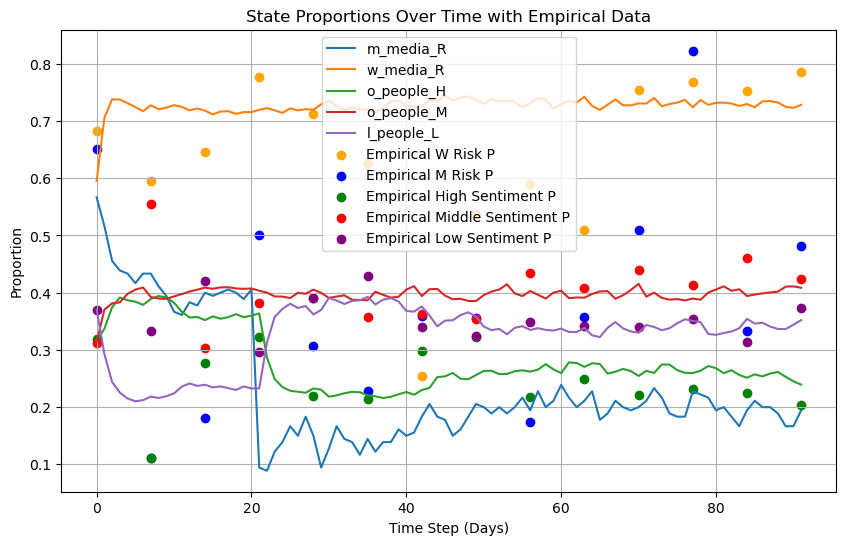

In [146]:
plot_history_with_empirical(history, empirical_data_another) # 我对主流媒体的政府效应也进行了参数化

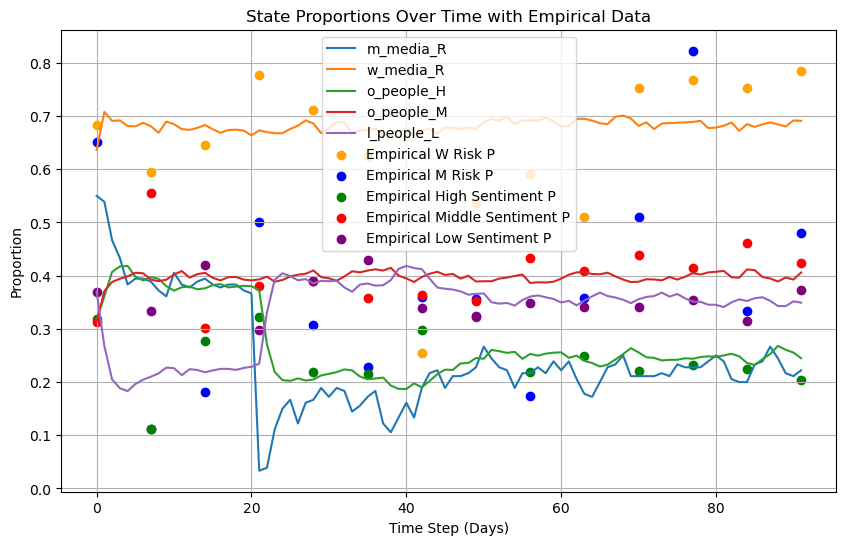

In [92]:
plot_history_with_empirical(history, empirical_data_another) # 我对主流媒体的政府效应也进行了参数化

媒体的信息作用有个自然衰减的效果

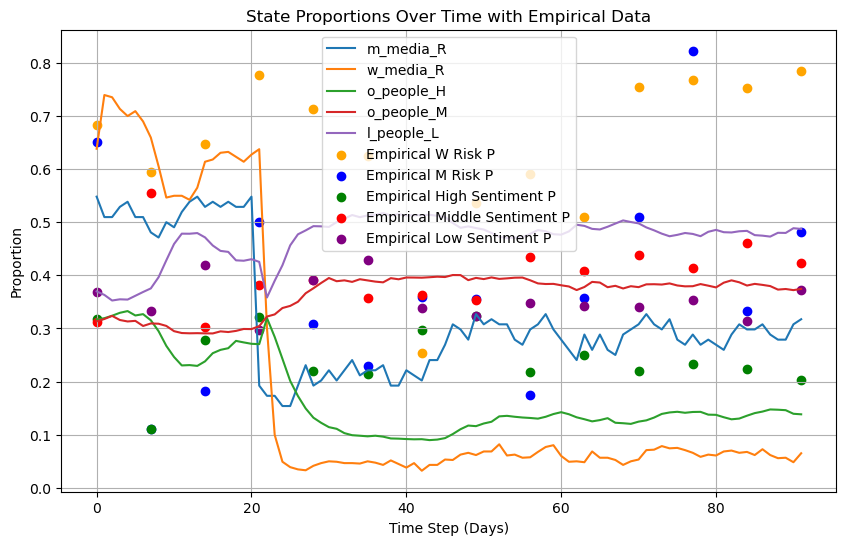

In [209]:
plot_history_with_empirical(history, empirical_data_another) # 将we media的risk从local 改成了 global

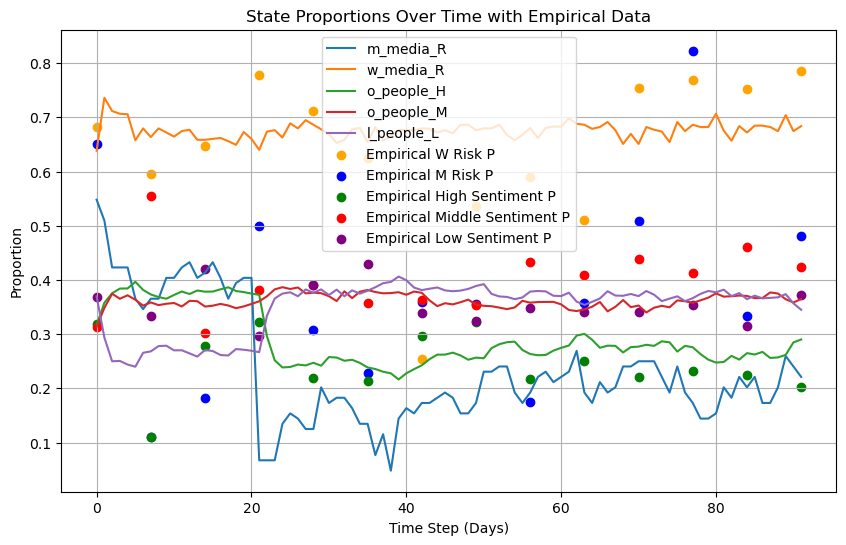

In [205]:
plot_history_with_empirical(history, empirical_data_another) # 我修改了mainsream media 的d

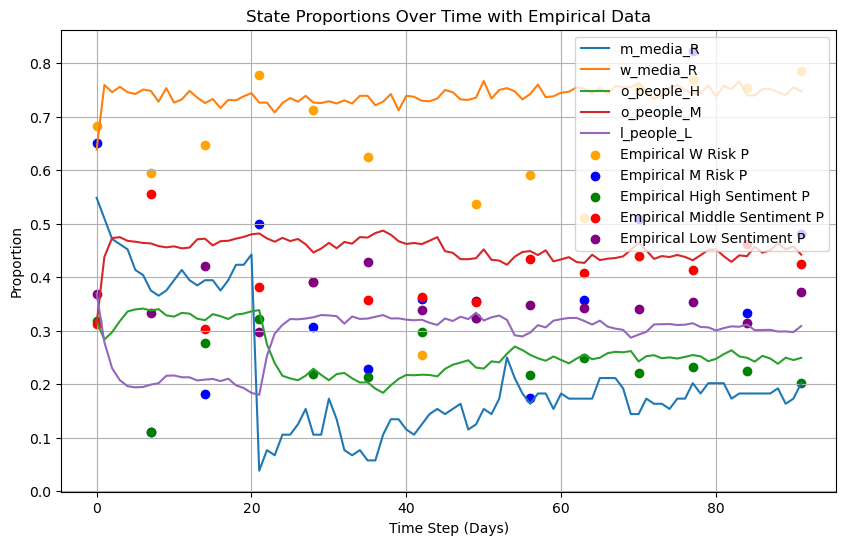

In [200]:
plot_history_with_empirical(history, empirical_data_another) # 我开始修改mainstream media的机制

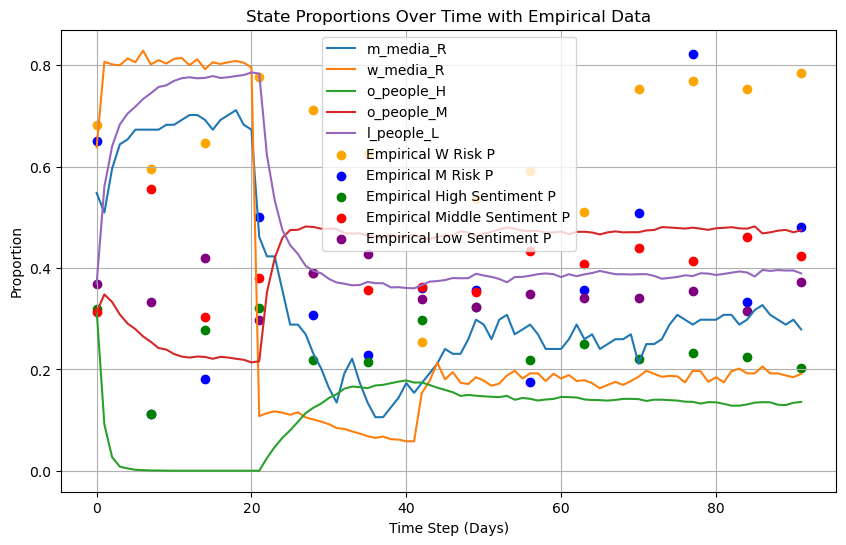

In [186]:
plot_history_with_empirical(history, empirical_data_another) # 我开始修改mainstream media的机制

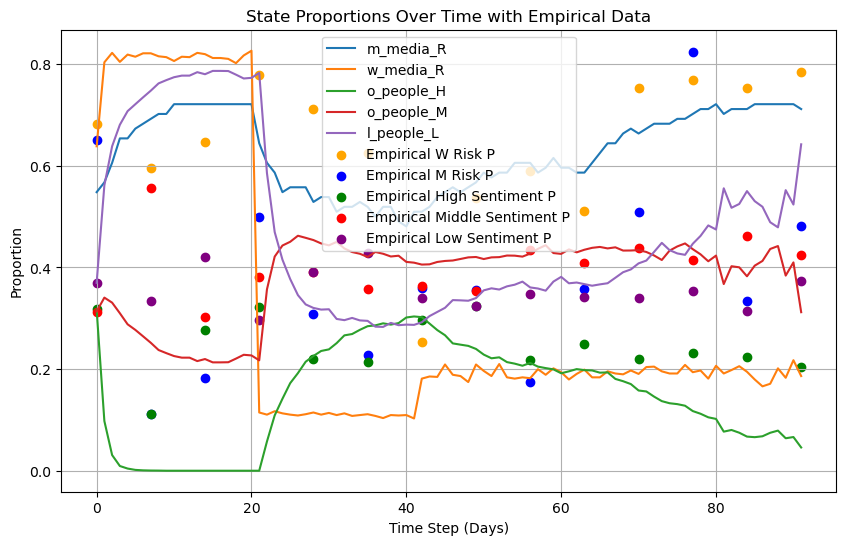

In [182]:
plot_history_with_empirical(history, empirical_data_another) # 我开始修改mainstream media的机制

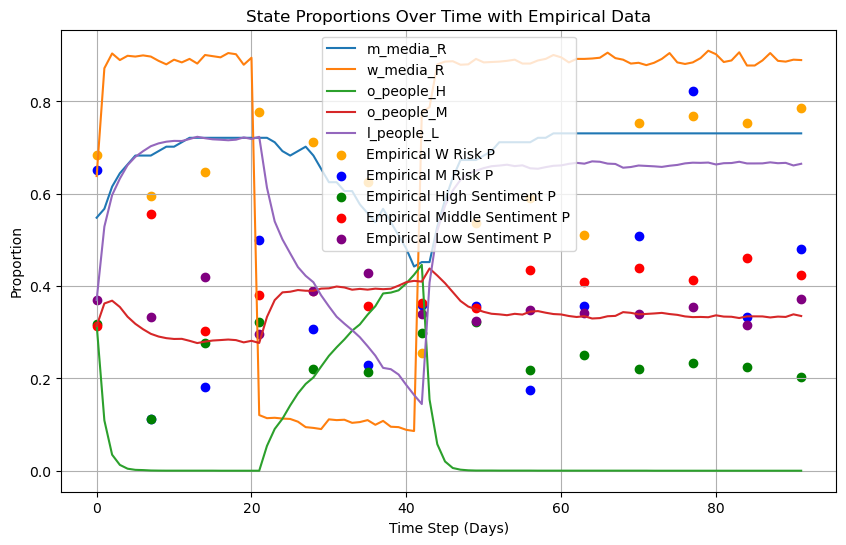

In [178]:
plot_history_with_empirical(history, empirical_data_another) # 我去掉了非gv wemedia的NR机制

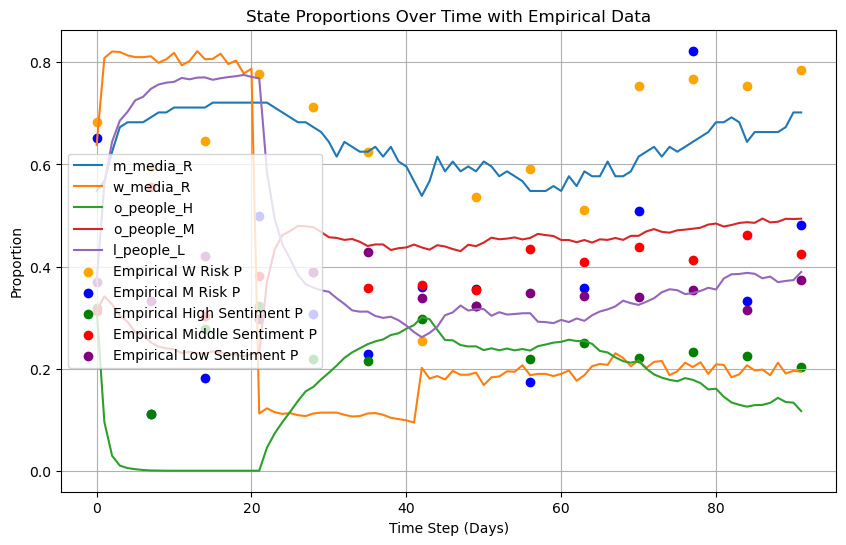

In [174]:
plot_history_with_empirical(history, empirical_data_another) # 我加入了政府效应，修改了分母

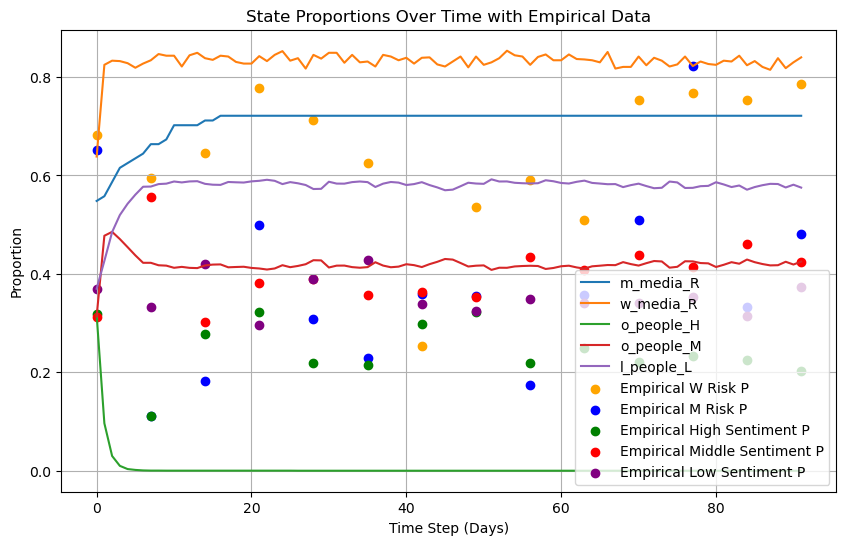

In [146]:
plot_history_with_empirical(history, empirical_data_another) # 我没有设定政府效应

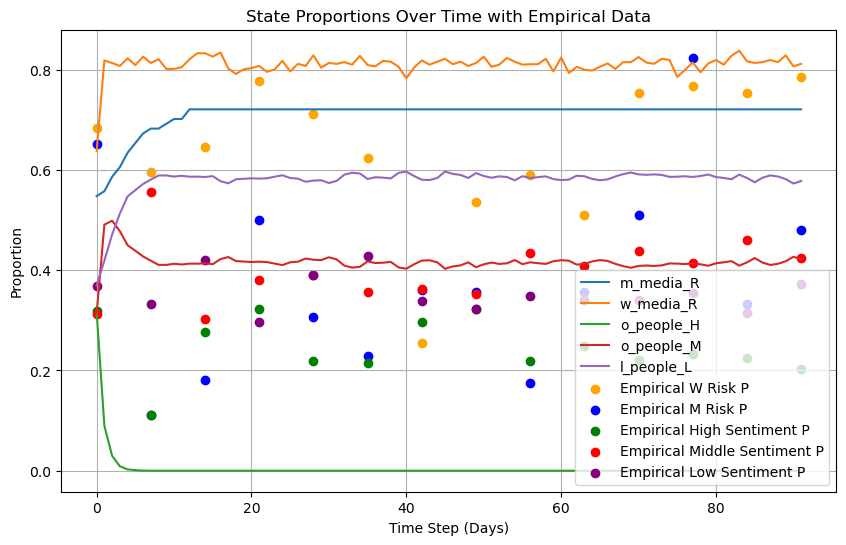

In [128]:
plot_history_with_empirical(history, empirical_data_another) # 我还是设定了一个政府效应的时期

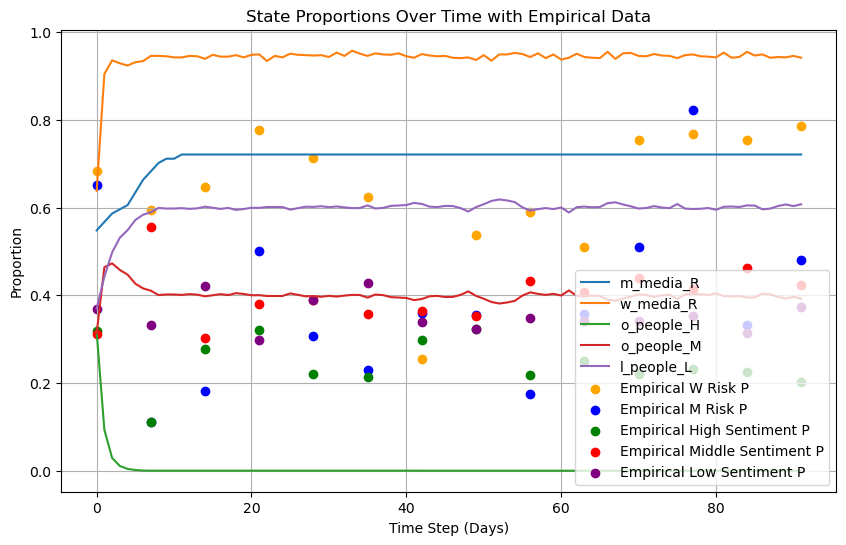

In [107]:
plot_history_with_empirical(history, empirical_data_another) # 

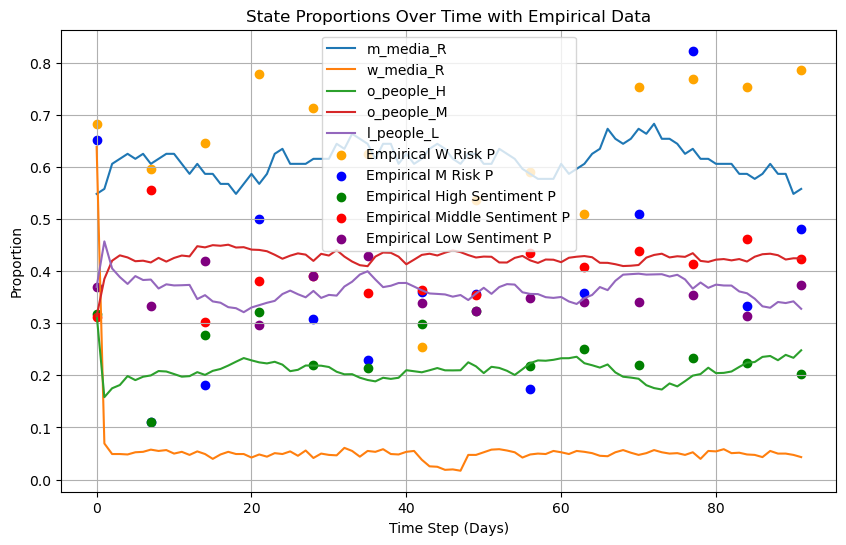

In [96]:
plot_history_with_empirical(history, empirical_data_another) # 去掉了所有的gv，并且对情感的转向计算进行了修改，补充了自媒体的风险计算规则

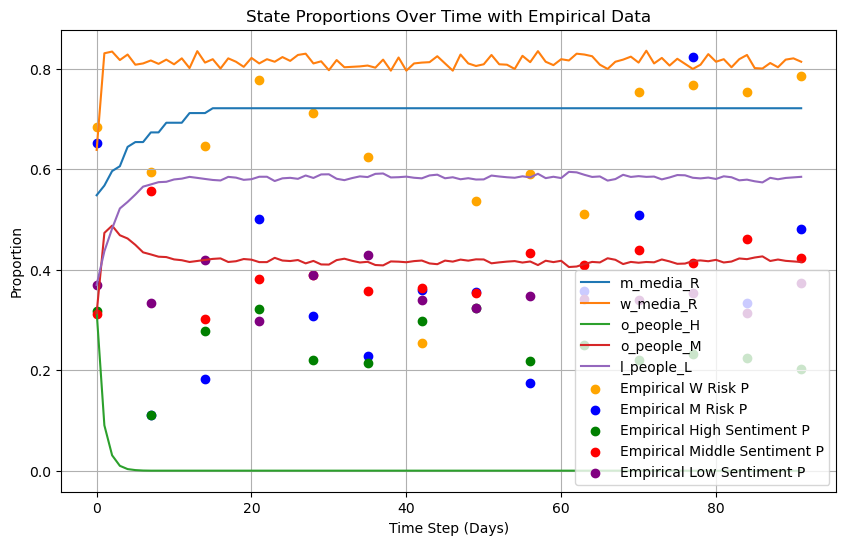

In [87]:
plot_history_with_empirical(history, empirical_data_another) # 去掉了所有的gv，并且对情感的转向计算进行了修改，补充了自媒体的风险计算规则

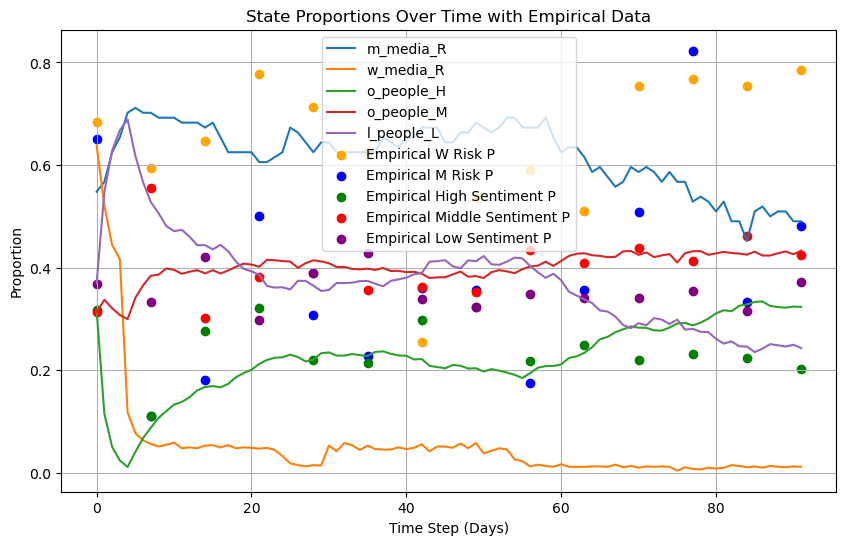

In [70]:
plot_history_with_empirical(history, empirical_data_another) # 去掉了所有的gv，并且对情感的转向计算进行了修改

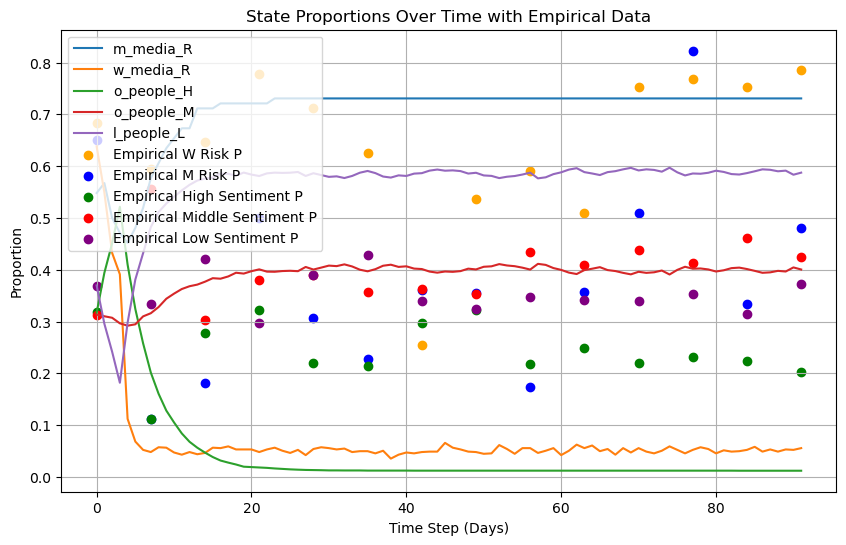

In [44]:
plot_history_with_empirical(history, empirical_data_another) # 去掉了所有的gv

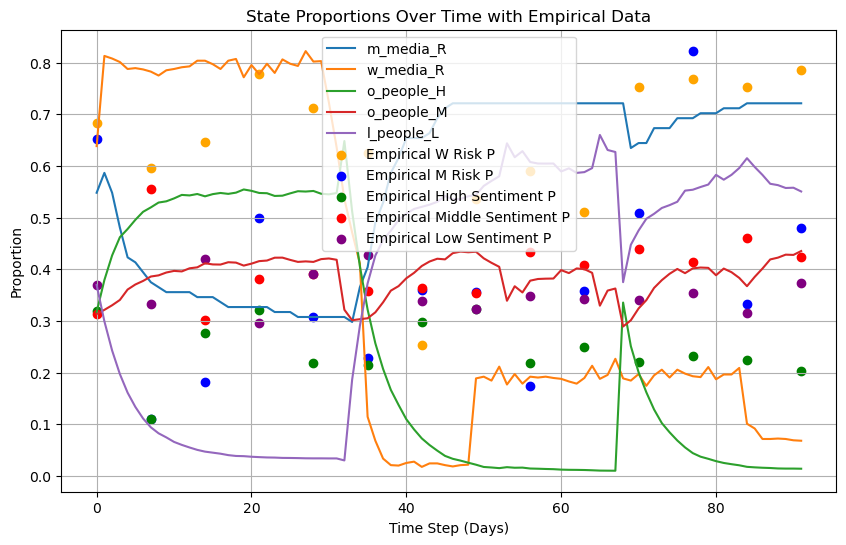

In [29]:
plot_history_with_empirical(history, empirical_data_another) # 我的政府版自媒体效应恢复了，形状也就恢复到了之前的情况

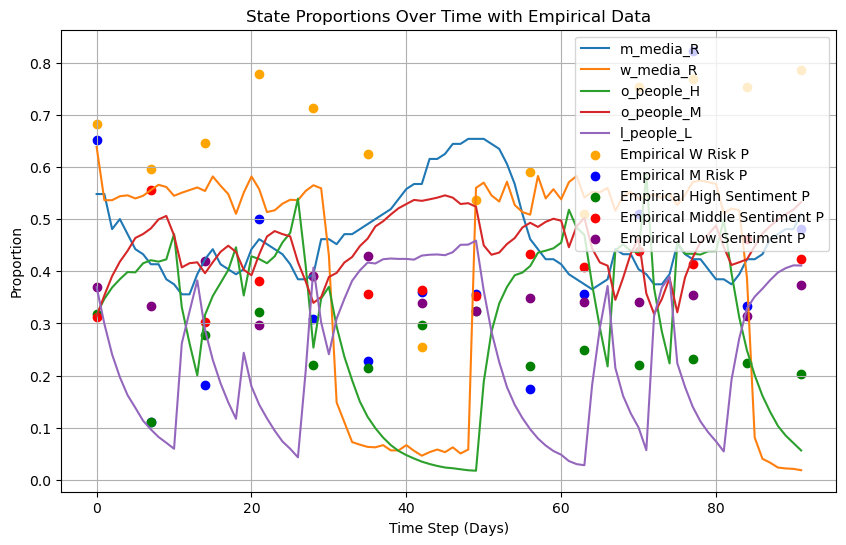

In [23]:
plot_history_with_empirical(history, empirical_data_another) # 我修复了一些tanh公式

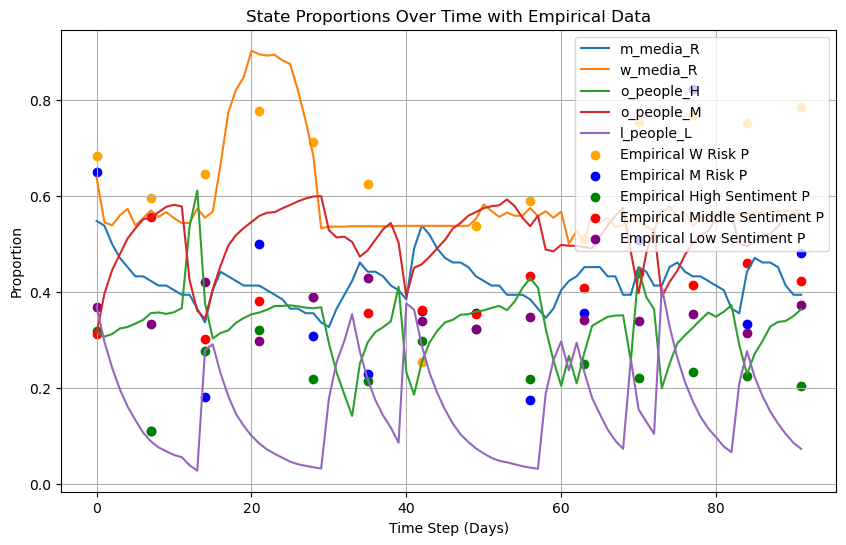

In [18]:
plot_history_with_empirical(history, empirical_data_another) # 去掉自媒体的norisk

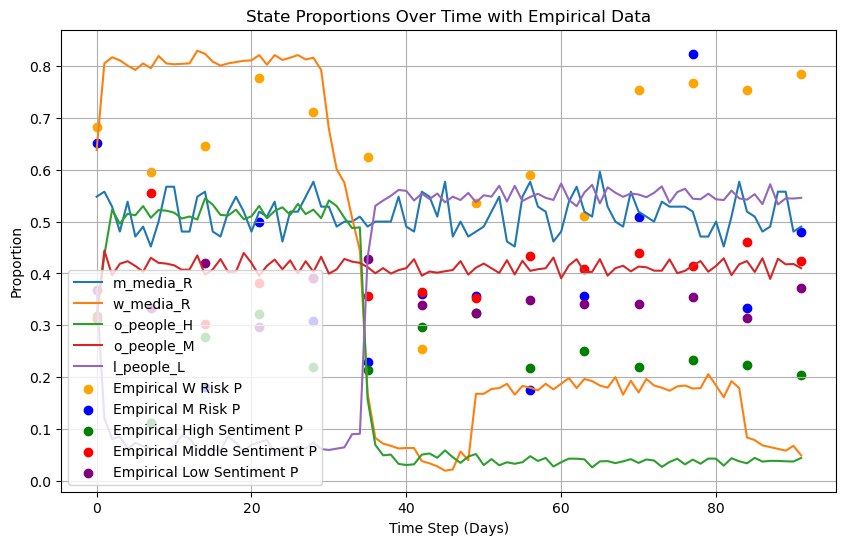

In [13]:
plot_history_with_empirical(history, empirical_data_another) # 这里情感上使用了entrophy

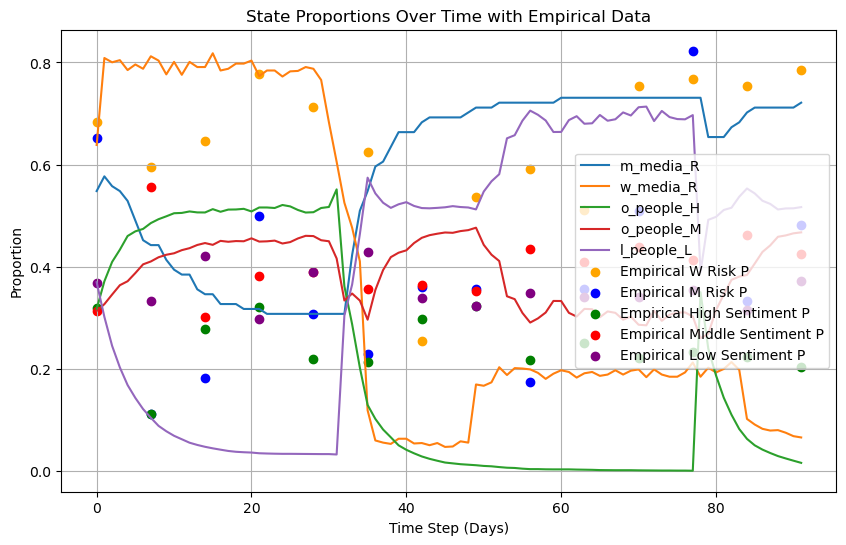

In [24]:
plot_history_with_empirical(history, empirical_data_another) # 这个结果很有特点，但是准确率还也有待提高

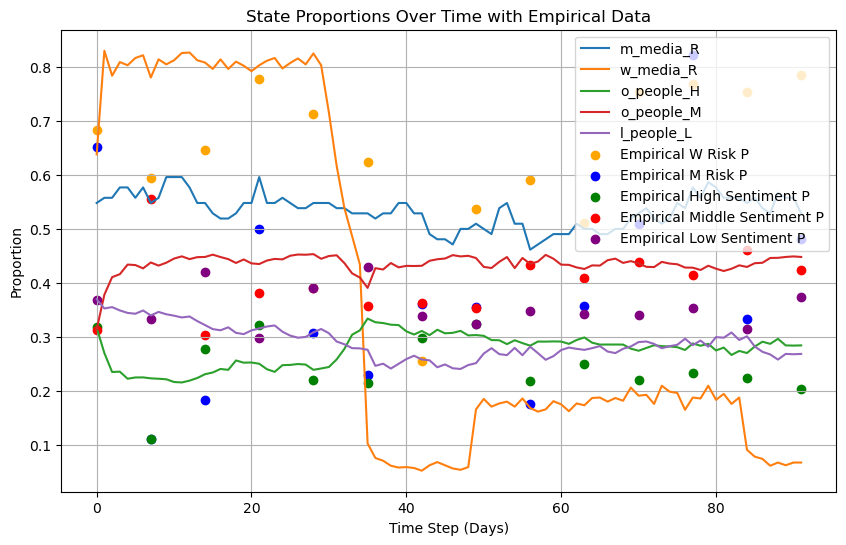

In [11]:
plot_history_with_empirical(history, empirical_data_another) 

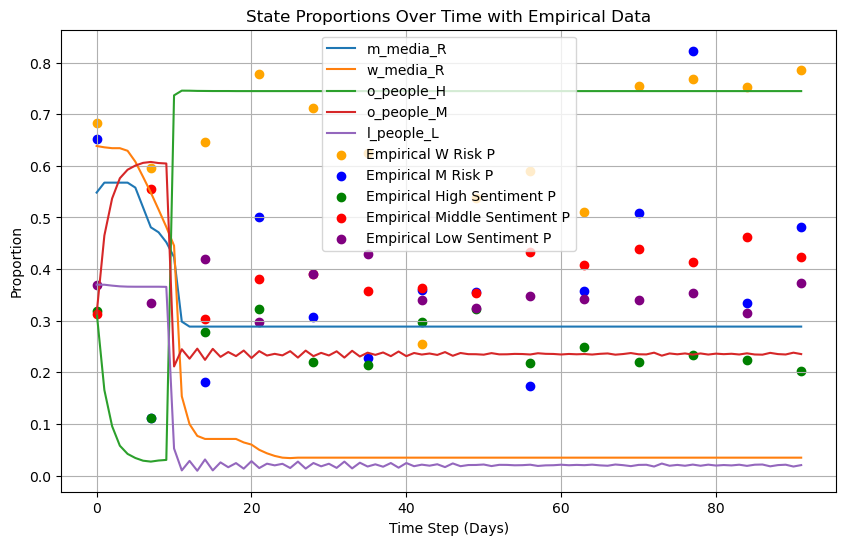

In [21]:
# 加入第四个政府效应
plot_history_with_empirical(history, empirical_data_another) 

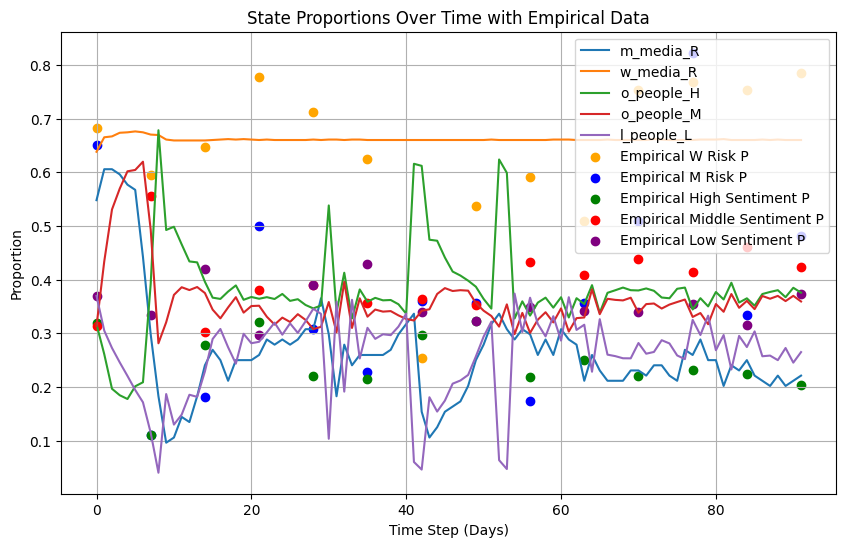

In [32]:
# 加入第三个政府效应
plot_history_with_empirical(history, empirical_data_another) 

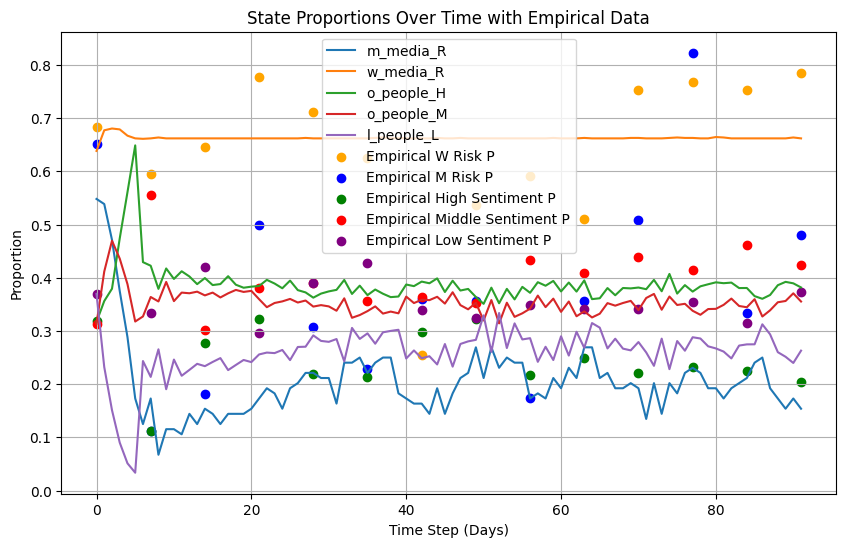

In [21]:
# 加入第二个政府效应
plot_history_with_empirical(history, empirical_data_another) 

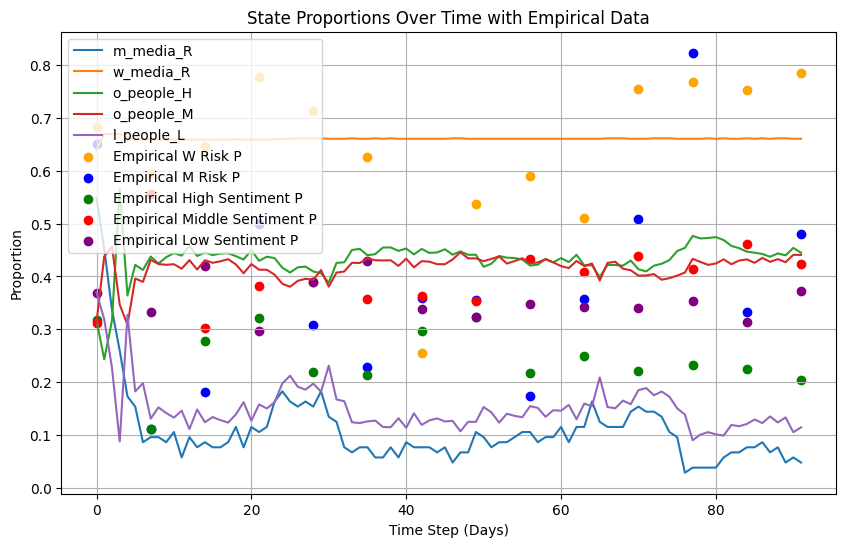

In [13]:
# 这里没加政府效应
plot_history_with_empirical(history, empirical_data_another) 

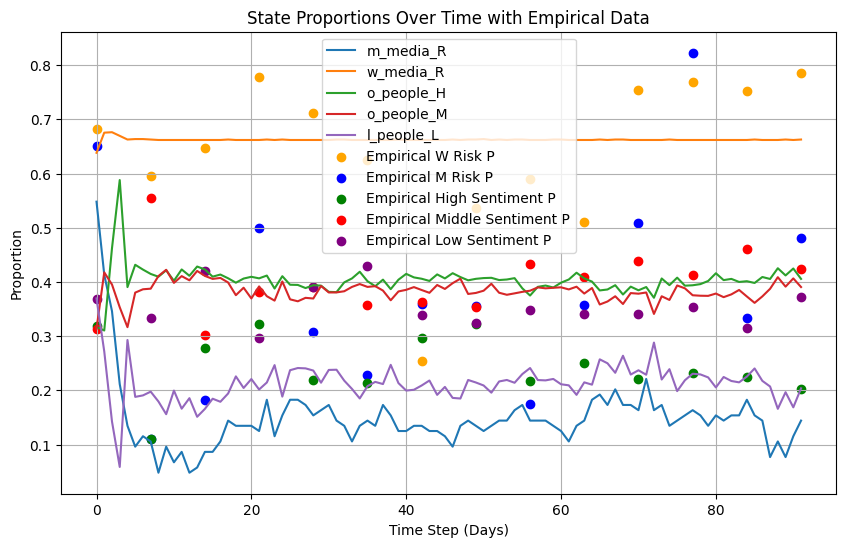

In [17]:
# 这个结果是加了第一个政府效应
plot_history_with_empirical(history, empirical_data_another) 

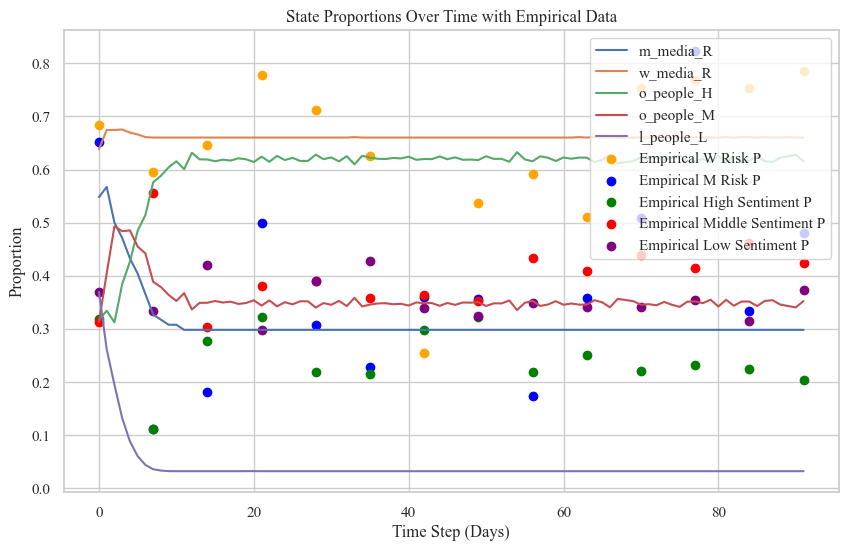

In [117]:
plot_history_with_empirical(history, empirical_data_another)

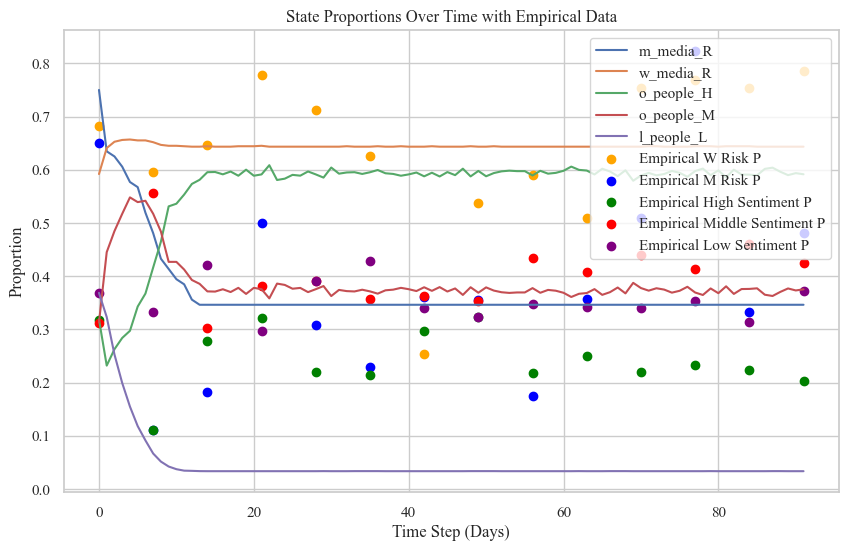

In [60]:
plot_history_with_empirical(history, empirical_data_another)

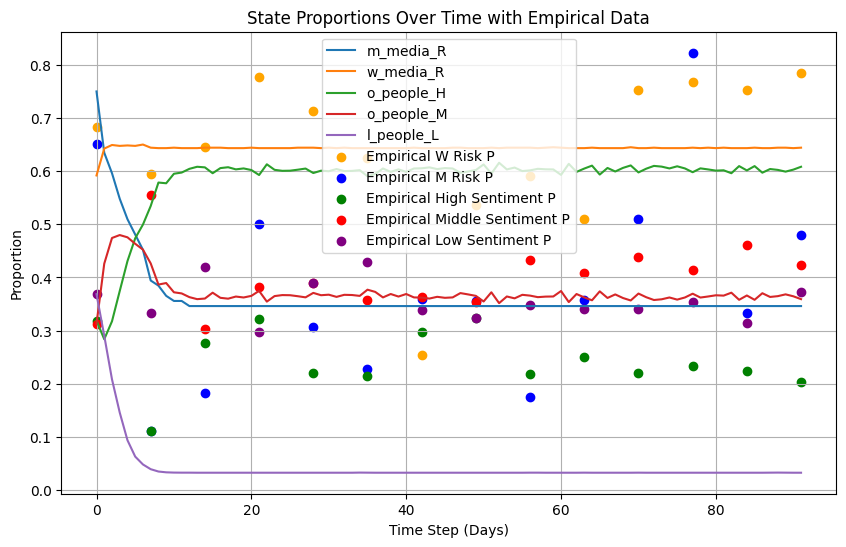

In [35]:
# alpha, beta, theta = all_results[all_results['error'] == all_results['error'].min()]['alpha'].values[0], all_results[all_results['error'] == all_results['error'].min()]['beta'].values[0], all_results[all_results['error'] == all_results['error'].min()]['theta'].values[0]

plot_history_with_empirical(history, empirical_data_another)

In [2]:
import joblib
import pandas as pd
network_first = joblib.load('network_sigmoid_wt_v4.pkl')

In [28]:
# 首先将三类节点各自生成一张网络，然后利用邻接矩阵的方式将三张网络连接起来
# 那么第一层网络layer1: m_media, layer2: w_media, layer3: o_people

# 获取network_first的所有节点的信息
nodes = []
for name, node in network_end.nodes.items():
    nodes.append(node)
    
len(nodes)
# 将nodes随机抽出0.4
import random
random.shuffle(nodes)
nodes = nodes[:int(len(nodes)*0.4)]

10370

In [5]:
network_data = []
for id, node in enumerate(nodes):
    if nodes[id].type == 'm_media':
        SourceLayer = 1
    elif nodes[id].type == 'w_media':
        SourceLayer = 2
    else:
        SourceLayer = 3
    SourceNode = nodes[id].name
    Targets = [(influencer.name, influencer.type) for influencer in nodes[id].influencers]
    for target in Targets:
        TargetNode = target[0]
        if target[1] == 'm_media':
            TargetLayer = 1
        elif target[1] == 'w_media':
            TargetLayer = 2
        else:
            TargetLayer = 3
        network_data.append([SourceNode, TargetNode, SourceLayer, TargetLayer])

In [6]:
# 将network_data转换为DataFrame，并存储为tsv文件
network_df = pd.DataFrame(network_data, columns=['SourceNode', 'TargetNode', 'SourceLayer', 'TargetLayer'])
network_df.shape

(11604, 4)

In [7]:
# 筛选出 SourceLayer 或 TargetLayer 为 3 且不同时为 3 的样本
to_potentially_remove = network_df[((network_df['SourceLayer'] == 3) | (network_df['TargetLayer'] == 3)) & ~((network_df['SourceLayer'] == 3) & (network_df['TargetLayer'] == 3))]

# 从这些样本中随机选择 50% 来删除
indices_to_remove = to_potentially_remove.sample(frac=0.7, random_state=42).index  # random_state for reproducibility

# 从原始数据框中删除这些样本
network_df = network_df.drop(indices_to_remove)

network_df.shape

(4513, 4)

In [9]:
network_df.to_csv('./output/network/network.tsv', sep='\t', index=False)

In [33]:
network_df = pd.read_csv('./output/network/network.tsv', sep='\t')

In [48]:
network_ini = joblib.load('network_sigmoid_wt_v4.pkl')
history = network_ini.simulate_steps(62, alpha, beta, theta, delta_1, delta_2, delta_3, delta_4, gamma_1, gamma_2, gamma_3, gamma_4)
network_end = network_ini

In [49]:
nodes_1 = list(set(network_df['SourceNode'].to_list() + network_df['TargetNode'].to_list()))
print(len(nodes_1))
nodes_for_attr = []
for name, node in network_end.nodes.items():
    if name in nodes_1:
        nodes_for_attr.append(node)

1285


In [50]:
# 现在生成node_attribute数据，主要是节点的颜色，每一层的节点按照状态进行颜色选择，包含四种颜色：risk:#ccdc29, no_risk:#F8B04A，polar:#b84665, moderate:#605c8c
node_attribute_data = []
for id, node in enumerate(nodes_for_attr):
    if nodes_for_attr[id].type == 'm_media':
        Layer = 1
        Size = 2
    elif nodes_for_attr[id].type == 'w_media':
        Layer = 2
        Size = 1.5
    else:
        Layer = 3
        Size = 1
    Node = nodes_for_attr[id].name
    if nodes_for_attr[id].type == 'm_media':
        if nodes_for_attr[id].risk == 'R':
            Color = '#CC011F'
        else:
            Color = '#074166'
    elif nodes_for_attr[id].type == 'w_media':
        if nodes_for_attr[id].risk == 'R':
            Color = '#CC011F'
        else:
            Color = '#074166'
    else:
        if nodes_for_attr[id].sentiment == 'M':
            Color = '#59B78F'
        else:
            Color = '#F2B134'
    node_attribute_data.append([Node, Layer, Color, Size])

In [51]:
# 将node_attribute_data转换为DataFrame，并存储为tsv文件
node_attribute_df = pd.DataFrame(node_attribute_data, columns=['Node', 'Layer', 'Color', 'Size'])
node_attribute_df.to_csv('./output/network/node_attribute_middle_2.tsv', sep='\t', index=False)

In [52]:
node_attribute_df[node_attribute_df['Layer'] == 3]['Color'].value_counts()

Color
#59B78F    321
#F2B134    231
Name: count, dtype: int64

In [104]:
empirical_data_another = {
    'w_risk_p': emp_w_risk_p,
    'm_risk_p': emp_m_risk_p,
    'sentiment_high_p': emp_sentiment_high_p,
    'sentiment_middle_p': emp_sentiment_middle_p,
    'sentiment_low_p': emp_sentiment_low_p
}

没必要了，感觉10-15这个参数范围不太可能，现在根据已有的组合结果去进行优化

In [277]:
results_0_1_0_5000 = pd.read_csv('results_0_1_0_5000.csv')
results_0_1_5000_10000 = pd.read_csv('results_0_1_5000_10000.csv')
results_1_5 = pd.read_csv('results_1_5.csv')
results_5_10 = pd.read_csv('results_5_10.csv')
results_10_15 = pd.read_csv('results_10_15.csv')

In [278]:
all_results = pd.concat([results_0_1_0_5000, results_0_1_5000_10000, results_1_5, results_5_10, results_10_15])

In [283]:
all_results.to_csv('all_results.csv', index=False)

In [296]:
# 从all_results中提取出alpha, beta, theta这三列，它们集中在param列中，'(0.5244277514493755, 0.765501359216343, 0.6221949262948713)'，以逗号分隔
all_results['alpha'] = all_results['param'].apply(lambda x: x.split(',')[0][1:]).astype('float')
all_results['beta'] = all_results['param'].apply(lambda x: x.split(',')[1]).astype('float')
all_results['theta'] = all_results['param'].apply(lambda x: x.split(',')[2][:-1]).astype('float')


In [302]:
all_results = all_results.sort_values('error', ascending=True)

In [309]:
i = 3
alpha, beta, theta = all_results.iloc[i]['alpha'], all_results.iloc[i]['beta'], all_results.iloc[i]['theta']
alpha, beta, theta 

(6.414043609299396, 9.458660745992887, 5.918834038085581)

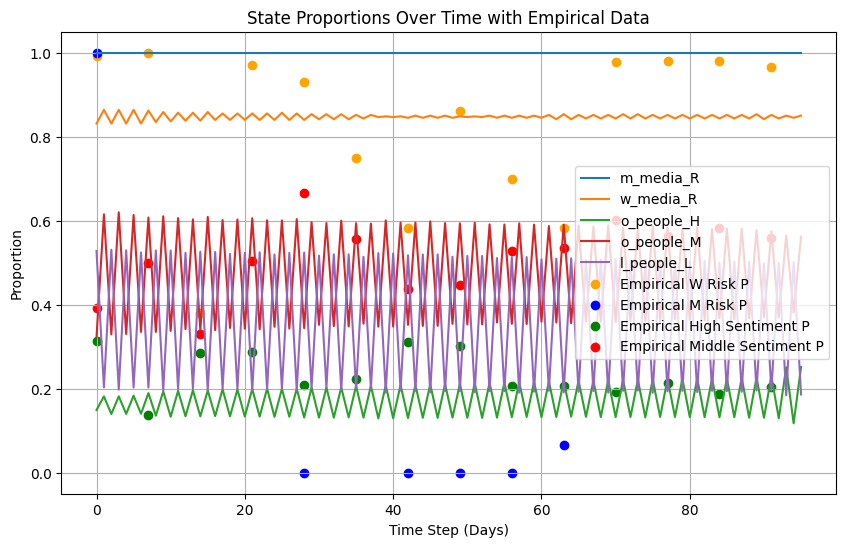

In [310]:
# alpha, beta, theta = all_results[all_results['error'] == all_results['error'].min()]['alpha'].values[0], all_results[all_results['error'] == all_results['error'].min()]['beta'].values[0], all_results[all_results['error'] == all_results['error'].min()]['theta'].values[0]
network_ini = joblib.load('newworks/simple.pkl')
history = network.simulate_steps(95, alpha, beta, theta, sigma)

plot_history_with_empirical(history, empirical_data)

In [301]:
network_ini = joblib.load('network.pkl')
best_param = alpha, beta, theta
simulate_network_for_parameters(network_ini, best_param, num_seeds=10)

{'result': 'not fitting',
 'param': (8.967482352648515, 9.323592077042193, 8.972570406951892),
 'error': 0.1594889177594919}

In [150]:
network_ini = joblib.load('network.pkl')

In [151]:
result = simulate_network_for_parameters(network, *best_param, num_seeds=10)

In [152]:
result

{'result': 'not fitting',
 'param': (0.40952465598899357, 0.6752898090248068, 0.016232326718585988),
 'error': 0.15804405635756646}

In [ ]:
import concurrent.futures
import tqdm
import joblib

# 示例: 使用并行处理加速模拟的函数
def simulate_with_params(param):
    network = joblib.load('network.pkl')  # 假设network.pkl是你的网络模型
    result = simulate_network_for_parameters(network, param, num_seeds=10)
    return param, result

all_params = [...]  # 假设这是你的参数列表
results = []

# 使用并行处理
with concurrent.futures.ProcessPoolExecutor() as executor:
    # 使用tqdm显示进度条
    futures = [executor.submit(simulate_with_params, param) for param in all_params[:100]]
    for future in tqdm.tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc='Simulating'):
        param, result = future.result()
        results.append(result)
        if result != 'not fitting':
            print(param, result)


In [ ]:
all_results = [simulate_network_for_parameters(network, params) for params in all_params]
# 你需要在某处定义或获取你的经验数据
selected_params = select_parameters_based_on_error(all_params, all_results, empirical_data)

def select_parameters_based_on_error(all_params, all_results, empirical_data):
    """
    根据指定的误差阈值选择参数组合。
    """
    selected_params = []
    for params, results in zip(all_params, all_results):
        # 实现基于结果和经验数据的误差计算
        error = calculate_error(results, empirical_data)
        if meets_error_criteria(error):
            selected_params.append(params)
    return selected_params

# 示例用法:
network = Network()
# 在这里初始化你的网络
all_params = sample_parameter_combinations()
all_results = [simulate_network_for_parameters(network, params) for params in all_params]
# 你需要在某处定义或获取你的经验数据
selected_params = select_parameters_based_on_error(all_params, all_results, empirical_data)


### 遗传算法

为了实现模型参数校准，并结合遗传算法（GA）的概念，我将为你提供一个更新和更完整的代码示例。这个示例将包含用于执行参数校准的基础结构，包括模拟模型、遗传算法的实现框架，以及如何根据适应度评分选择参数组合。我还将提供一个简化的测试案例来展示如何运用这个框架。

### 步骤 1: 模型定义

首先，我们定义`Node`和`Network`类，以及模拟执行函数。由于篇幅限制，我将使用你提供的类定义，并直接跳到遗传算法的实现。

### 步骤 2: 遗传算法的实现

我们将实现遗传算法来优化模型参数。这将包括初始化参数集合、评估适应度、选择、交叉和变异。

### 步骤 3: 模拟测试和参数校准

我们将运行一个简化的模拟测试来演示整个流程如何工作。

请注意，为了使示例尽可能简洁，我将省略一些实际应用中可能需要的详细实现，比如详细的适应度评分计算和模型的具体行为。

```python
import numpy as np
import pandas as pd
from collections import Counter
import math

# 假设 Node 和 Network 类已根据你的代码定义

class GeneticAlgorithm:
    def __init__(self, network, empirical_data, population_size=30, mutation_rate=0.1, generations=100):
        self.network = network
        self.empirical_data = empirical_data
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.parameter_ranges = {'alpha': (0.01, 1.0), 'beta': (0.01, 1.0), 'theta': (0.01, 1.0)}
    
    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            individual = {key: np.random.uniform(low, high) for key, (low, high) in self.parameter_ranges.items()}
            population.append(individual)
        return population
    
    def calculate_fitness(self, simulated_data, empirical_data):
        # 简化的适应度评分计算，实际应用中需要根据具体情况设计
        mse = np.mean((simulated_data - empirical_data) ** 2)
        return -mse
    
    def simulate(self, params):
        # 这里应调用你的模拟逻辑，返回模拟数据
        # 为了示例，我们返回一些随机生成的数据
        return np.random.rand(90)
    
    def evolve(self):
        population = self.initialize_population()
        for generation in range(self.generations):
            fitness_scores = []
            for individual in population:
                simulated_data = self.simulate(individual)
                fitness = self.calculate_fitness(simulated_data, self.empirical_data)
                fitness_scores.append((individual, fitness))
            
            # 选择
            fitness_scores.sort(key=lambda x: x[1], reverse=True)
            survivors = fitness_scores[:int(self.population_size * 0.4)]
            
            # 生成下一代
            new_population = [individual for individual, _ in survivors]
            while len(new_population) < self.population_size:
                parent1, parent2 = np.random.choice([ind for ind, _ in survivors], 2, replace=False)
                child = {key: np.random.choice([parent1[key], parent2[key]]) for key in parent1}
                # 变异
                if np.random.rand() < self.mutation_rate:
                    mutation_key = np.random.choice(list(child.keys()))
                    child[mutation_key] = np.random.uniform(*self.parameter_ranges[mutation_key])
                new_population.append(child)
            
            population = new_population
        return population

# 示例用法
network = Network()
empirical_data = np.random.rand(90)  # 假设的经验数据，实际应用中应替换为真实数据
ga = GeneticAlgorithm(network, empirical_data)
optimized_parameters = ga.evolve()
```

这段代码实现

了一个基础的遗传算法，用于寻找最优化的模型参数。`GeneticAlgorithm`类初始化时需要一个网络对象和经验数据，然后通过`evolve`方法进行参数优化。这里的`simulate`方法和`calculate_fitness`方法需要根据你的具体模型和适应度评分标准进行实现和调整。

### 注意

- 上述代码中的`simulate`函数是模拟执行的地方，你需要根据你的模型具体实现这一部分。
- `calculate_fitness`方法也是简化的，你需要根据实际情况来计算适应度评分。
- 由于篇幅和复杂性限制，这里没有展示如何将节点和网络的详细状态纳入模拟和适应度评分计算中。这需要你根据你的具体模型和数据进行设计。